# Task 1: Classification

- define a Neural Network
- def

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset

In [2]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)


idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


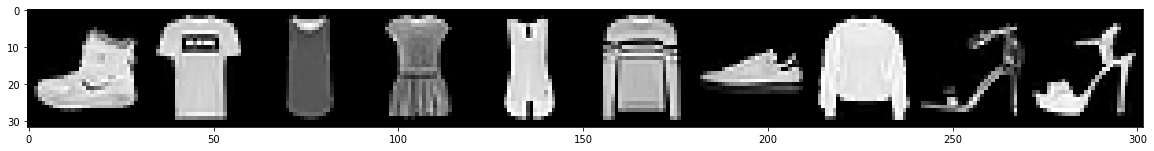

In [3]:
x = [train_dataset[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

In [4]:
# use cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [5]:
# class defining neural network
# input layer is linear, takes 28*28 input parameters, outputs 512 uses ReLU
# 1 hidden layer input 512, output 512 uses ReLU()
# output layer, input 512, output 10, one for each class, uses ReLU()
# ReLU is widely used as it solves the problem of vanishing gradients
# nn uses bias term throughout network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We also tested some other activation functions such as sigmoid for the output layer, however, we achieved better results just using ReLU

In [6]:
# obtain and print the model
# execute model on device --> cuda if available
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): ReLU()
  )
)


In [7]:
# function for training
# @param dataloader: the data loader for the training set
# @param model: the previously defined neural network model
# @param loss_fn: defined loss function
# @param optimizer: how we calculate the loss
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # move X and y to gpu if available
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# function for testing
# @param dataloader: the data loader for the training set
# @param model: the previously defined neural network model after training
# @param loss_fn: defined loss function
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # move X and y to gpu if available
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
# define hyper params
# updating rate for each batch/epoch
# empirical evaluation found that 1e-3 works better than other values
learning_rate = 1e-3
# number of data samples to propagate through network before updating params
batch_size = 64
# iteration times
# We tested with different epoch sizes, however, due to the pdf form, we decided to 
# stay at 50 to not have a really large pdf
epochs = 50
# using CrossEntropy for numeric stability, combines LogSoftmax and NLLLoss
# useful when training a problem with C classes
loss_fn = nn.CrossEntropyLoss()
# defining the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# use data loader to obtain batch training and test data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 20, shuffle=True)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 6.659163  [    0/60000]
loss: 6.634620  [ 2000/60000]
loss: 6.604107  [ 4000/60000]
loss: 6.500693  [ 6000/60000]
loss: 6.501466  [ 8000/60000]
loss: 6.285739  [10000/60000]
loss: 6.181007  [12000/60000]
loss: 6.048857  [14000/60000]
loss: 5.470643  [16000/60000]
loss: 3.688171  [18000/60000]
loss: 4.683969  [20000/60000]
loss: 3.433100  [22000/60000]
loss: 3.865809  [24000/60000]
loss: 4.424966  [26000/60000]
loss: 3.915787  [28000/60000]
loss: 4.042671  [30000/60000]
loss: 3.264639  [32000/60000]
loss: 3.542874  [34000/60000]
loss: 4.438230  [36000/60000]
loss: 3.105624  [38000/60000]
loss: 4.270744  [40000/60000]
loss: 2.936469  [42000/60000]
loss: 3.731812  [44000/60000]
loss: 3.576220  [46000/60000]
loss: 3.143201  [48000/60000]
loss: 3.769495  [50000/60000]
loss: 2.770670  [52000/60000]
loss: 3.665986  [54000/60000]
loss: 4.063390  [56000/60000]
loss: 4.017674  [58000/60000]
Test Error: 
 Accuracy: 37.7%, Avg loss: 0.182739 

Epoch 2


loss: 2.045938  [16000/60000]
loss: 1.697475  [18000/60000]
loss: 1.259605  [20000/60000]
loss: 1.630184  [22000/60000]
loss: 1.104853  [24000/60000]
loss: 1.057830  [26000/60000]
loss: 0.711312  [28000/60000]
loss: 1.676739  [30000/60000]
loss: 1.329903  [32000/60000]
loss: 0.592808  [34000/60000]
loss: 0.550494  [36000/60000]
loss: 1.048864  [38000/60000]
loss: 1.016789  [40000/60000]
loss: 0.766682  [42000/60000]
loss: 0.686866  [44000/60000]
loss: 0.676689  [46000/60000]
loss: 0.731731  [48000/60000]
loss: 0.301070  [50000/60000]
loss: 0.443153  [52000/60000]
loss: 0.909241  [54000/60000]
loss: 0.863136  [56000/60000]
loss: 0.331706  [58000/60000]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.030398 

Epoch 10
-------------------------------
loss: 0.417514  [    0/60000]
loss: 0.578139  [ 2000/60000]
loss: 0.420469  [ 4000/60000]
loss: 0.659393  [ 6000/60000]
loss: 0.586010  [ 8000/60000]
loss: 0.578119  [10000/60000]
loss: 0.971575  [12000/60000]
loss: 0.550236  [14000/60000]
loss: 0

loss: 0.412980  [34000/60000]
loss: 0.342917  [36000/60000]
loss: 0.326689  [38000/60000]
loss: 0.556963  [40000/60000]
loss: 0.695602  [42000/60000]
loss: 0.543009  [44000/60000]
loss: 0.650551  [46000/60000]
loss: 0.559271  [48000/60000]
loss: 0.324879  [50000/60000]
loss: 0.290214  [52000/60000]
loss: 0.272712  [54000/60000]
loss: 0.296236  [56000/60000]
loss: 0.562023  [58000/60000]
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.024696 

Epoch 18
-------------------------------
loss: 0.794506  [    0/60000]
loss: 0.578484  [ 2000/60000]
loss: 0.446716  [ 4000/60000]
loss: 0.558437  [ 6000/60000]
loss: 0.466792  [ 8000/60000]
loss: 1.072482  [10000/60000]
loss: 0.416468  [12000/60000]
loss: 0.369850  [14000/60000]
loss: 0.424504  [16000/60000]
loss: 0.837162  [18000/60000]
loss: 0.260128  [20000/60000]
loss: 0.446862  [22000/60000]
loss: 0.456297  [24000/60000]
loss: 0.715349  [26000/60000]
loss: 0.218237  [28000/60000]
loss: 0.187034  [30000/60000]
loss: 0.485019  [32000/60000]
loss: 0

loss: 0.300287  [52000/60000]
loss: 0.280213  [54000/60000]
loss: 0.460975  [56000/60000]
loss: 0.419864  [58000/60000]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.022937 

Epoch 26
-------------------------------
loss: 0.329790  [    0/60000]
loss: 0.661417  [ 2000/60000]
loss: 0.307133  [ 4000/60000]
loss: 0.230443  [ 6000/60000]
loss: 0.243392  [ 8000/60000]
loss: 0.341349  [10000/60000]
loss: 0.279817  [12000/60000]
loss: 0.335640  [14000/60000]
loss: 0.274711  [16000/60000]
loss: 0.589418  [18000/60000]
loss: 0.302777  [20000/60000]
loss: 0.393761  [22000/60000]
loss: 0.375301  [24000/60000]
loss: 0.541300  [26000/60000]
loss: 0.382885  [28000/60000]
loss: 0.398809  [30000/60000]
loss: 0.372435  [32000/60000]
loss: 0.406709  [34000/60000]
loss: 0.474806  [36000/60000]
loss: 0.296364  [38000/60000]
loss: 0.261549  [40000/60000]
loss: 0.555476  [42000/60000]
loss: 0.523683  [44000/60000]
loss: 0.425478  [46000/60000]
loss: 0.287648  [48000/60000]
loss: 0.499335  [50000/60000]
loss: 0

loss: 0.241526  [ 4000/60000]
loss: 0.497705  [ 6000/60000]
loss: 0.412923  [ 8000/60000]
loss: 0.855169  [10000/60000]
loss: 0.302219  [12000/60000]
loss: 0.320686  [14000/60000]
loss: 0.601021  [16000/60000]
loss: 0.518540  [18000/60000]
loss: 0.172240  [20000/60000]
loss: 0.606621  [22000/60000]
loss: 0.545365  [24000/60000]
loss: 0.442323  [26000/60000]
loss: 0.341450  [28000/60000]
loss: 0.387920  [30000/60000]
loss: 0.436618  [32000/60000]
loss: 0.529196  [34000/60000]
loss: 0.105415  [36000/60000]
loss: 0.281269  [38000/60000]
loss: 0.190055  [40000/60000]
loss: 0.486571  [42000/60000]
loss: 0.313179  [44000/60000]
loss: 0.536952  [46000/60000]
loss: 0.261443  [48000/60000]
loss: 0.269510  [50000/60000]
loss: 0.519705  [52000/60000]
loss: 0.368519  [54000/60000]
loss: 0.173580  [56000/60000]
loss: 0.179707  [58000/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.021807 

Epoch 35
-------------------------------
loss: 0.195148  [    0/60000]
loss: 0.491105  [ 2000/60000]
loss: 0

loss: 0.182090  [22000/60000]
loss: 0.384950  [24000/60000]
loss: 0.415713  [26000/60000]
loss: 0.440088  [28000/60000]
loss: 0.356864  [30000/60000]
loss: 0.240613  [32000/60000]
loss: 0.301331  [34000/60000]
loss: 0.297611  [36000/60000]
loss: 0.220604  [38000/60000]
loss: 0.212342  [40000/60000]
loss: 0.888635  [42000/60000]
loss: 0.618507  [44000/60000]
loss: 0.577854  [46000/60000]
loss: 0.164763  [48000/60000]
loss: 0.073755  [50000/60000]
loss: 0.374439  [52000/60000]
loss: 0.200528  [54000/60000]
loss: 0.237258  [56000/60000]
loss: 0.277098  [58000/60000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.020860 

Epoch 43
-------------------------------
loss: 0.457037  [    0/60000]
loss: 0.169292  [ 2000/60000]
loss: 0.354759  [ 4000/60000]
loss: 0.268487  [ 6000/60000]
loss: 0.169033  [ 8000/60000]
loss: 0.175171  [10000/60000]
loss: 0.512869  [12000/60000]
loss: 0.376474  [14000/60000]
loss: 0.265118  [16000/60000]
loss: 0.405198  [18000/60000]
loss: 0.337347  [20000/60000]
loss: 0

loss: 0.120267  [40000/60000]
loss: 0.355821  [42000/60000]
loss: 0.194458  [44000/60000]
loss: 0.334823  [46000/60000]
loss: 0.271909  [48000/60000]
loss: 0.333106  [50000/60000]
loss: 0.970565  [52000/60000]
loss: 0.574639  [54000/60000]
loss: 0.396736  [56000/60000]
loss: 0.744688  [58000/60000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.020144 

Done!


# Task 2: 

In [9]:
train_dataset = NoisyFashionMNIST("./data", True)
test_dataset = NoisyFashionMNIST("./data", False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


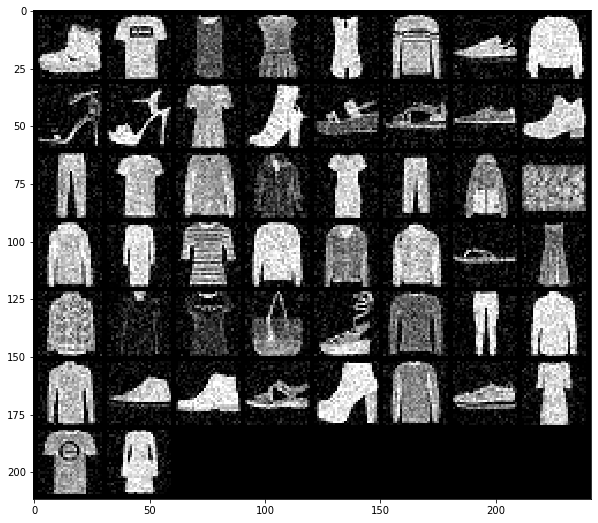

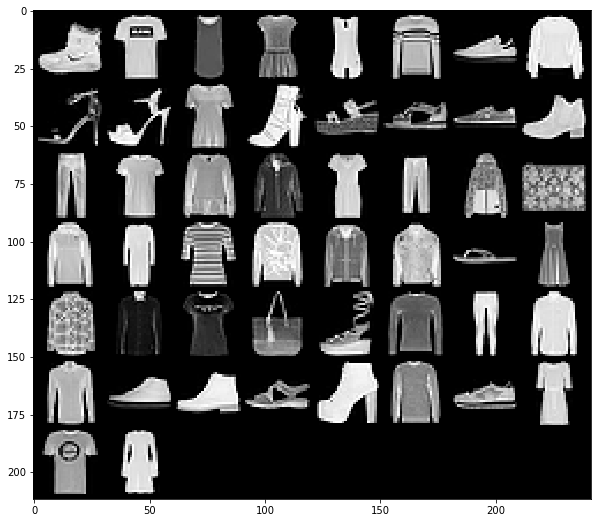

In [10]:
x = [train_dataset[i][0] for i in range(50)]
y = [train_dataset[i][1] for i in range(50)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(y))
plt.show()

## Autoencoder 
An autoencoder consists of an encoder and a decoder part. In the encoder part data is compressed to e.g. enable better identification of important data. We half the size of the input features until we reach 16. The decoder part decodes that encoded data again and in our case, transforms it back to its original input size by doubling the feature size in each layer. We found that linear layers together with relus are sufficient, to quickly and efficiently achieve good results. 

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # We found that simple linear layers are sufficient for the network to denoise 
        self.flatten = nn.Flatten()
        # encoder
        self.enc1 = nn.Linear(in_features=28*28, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=28*28)
        
    def forward(self, x):
        x = self.flatten(x)
        # relu works fast and reliable as activiation function
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x
    
model = Autoencoder()
model.to(device)
print(model)

Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


In [12]:
# function for training
# @param dataloader: the data loader for the training set
# @param model: the previously defined neural network model
# @param loss_fn: defined loss function
# @param optimizer: how we calculate the loss
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # move X and y to gpu if available
        X = X.to(device)
        y = y.to(device)
        y = torch.flatten(y, start_dim=1)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# function for testing, here we only do empirical testing --> we print the predictions, i.e. the denoised 
# pictures and the labels
# @param dataloader: the data loader for the training set
# @param model: the previously defined neural network model after training
def test_loop(dataloader, model):

    for X, y in dataloader:
        # move X and y to gpu if available
        X = X.to(device)
        y = y.to(device)
        img = y
        y = torch.flatten(y, start_dim=1)
        pred = model(X)
        pred = torch.reshape(pred, (20, 1, 28,28))
        pred = pred.cpu()
        img = img.cpu()
        
    x = [pred[i] for i in range(19)]
    y = [img[i] for i in range(19)]
    plt.figure(figsize=(10,10))
    show(torchvision.utils.make_grid(x))
    plt.show()
    plt.figure(figsize=(10,10))
    show(torchvision.utils.make_grid(y))
    plt.show()

After conducting some internet research, we found that denoising autoencoders are mostly evaluated by reviewing the test errors and comparing denoised pictures to labels. Hence, we refrain from calculating accuracy and instead display said pictures after each training epoch.

Epoch 1
-------------------------------
loss: 0.241252  [    0/60000]
loss: 0.117466  [ 2000/60000]
loss: 0.120310  [ 4000/60000]
loss: 0.062071  [ 6000/60000]
loss: 0.057809  [ 8000/60000]
loss: 0.053941  [10000/60000]
loss: 0.040293  [12000/60000]
loss: 0.049407  [14000/60000]
loss: 0.057688  [16000/60000]
loss: 0.072280  [18000/60000]
loss: 0.050666  [20000/60000]
loss: 0.053689  [22000/60000]
loss: 0.053847  [24000/60000]
loss: 0.062665  [26000/60000]
loss: 0.053468  [28000/60000]
loss: 0.044271  [30000/60000]
loss: 0.049811  [32000/60000]
loss: 0.041836  [34000/60000]
loss: 0.035506  [36000/60000]
loss: 0.051145  [38000/60000]
loss: 0.039259  [40000/60000]
loss: 0.035055  [42000/60000]
loss: 0.037451  [44000/60000]
loss: 0.040996  [46000/60000]
loss: 0.043236  [48000/60000]
loss: 0.031809  [50000/60000]
loss: 0.035170  [52000/60000]
loss: 0.042376  [54000/60000]
loss: 0.041742  [56000/60000]
loss: 0.038022  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


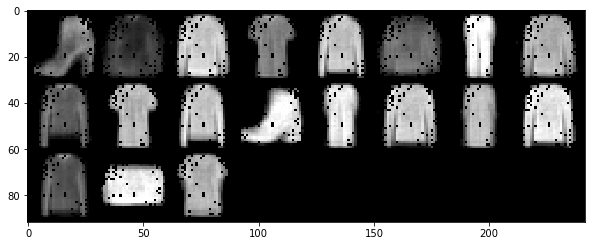

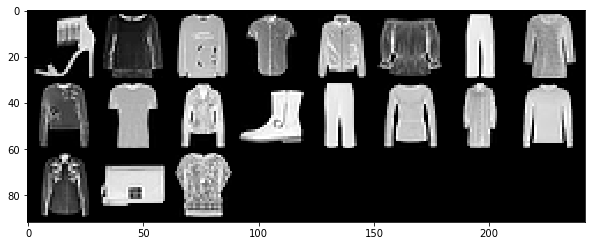

Epoch 2
-------------------------------
loss: 0.035346  [    0/60000]
loss: 0.030390  [ 2000/60000]
loss: 0.039968  [ 4000/60000]
loss: 0.032057  [ 6000/60000]
loss: 0.032130  [ 8000/60000]
loss: 0.034007  [10000/60000]
loss: 0.038569  [12000/60000]
loss: 0.036707  [14000/60000]
loss: 0.034573  [16000/60000]
loss: 0.037444  [18000/60000]
loss: 0.032280  [20000/60000]
loss: 0.032230  [22000/60000]
loss: 0.037252  [24000/60000]
loss: 0.032721  [26000/60000]
loss: 0.037024  [28000/60000]
loss: 0.027674  [30000/60000]
loss: 0.037107  [32000/60000]
loss: 0.032482  [34000/60000]
loss: 0.034344  [36000/60000]
loss: 0.030397  [38000/60000]
loss: 0.031307  [40000/60000]
loss: 0.033655  [42000/60000]
loss: 0.031323  [44000/60000]
loss: 0.036870  [46000/60000]
loss: 0.034712  [48000/60000]
loss: 0.025827  [50000/60000]
loss: 0.028278  [52000/60000]
loss: 0.039902  [54000/60000]
loss: 0.031779  [56000/60000]
loss: 0.032610  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


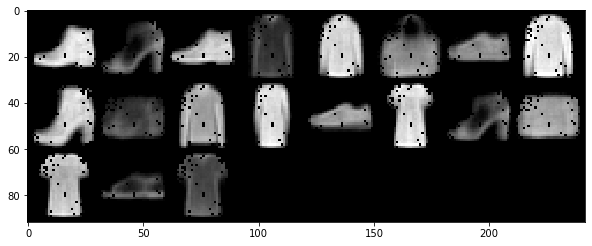

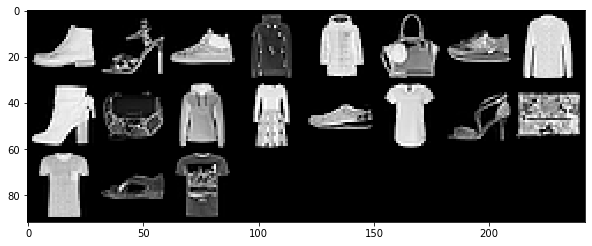

Epoch 3
-------------------------------
loss: 0.037479  [    0/60000]
loss: 0.030603  [ 2000/60000]
loss: 0.028677  [ 4000/60000]
loss: 0.033095  [ 6000/60000]
loss: 0.034482  [ 8000/60000]
loss: 0.029600  [10000/60000]
loss: 0.028973  [12000/60000]
loss: 0.028893  [14000/60000]
loss: 0.034826  [16000/60000]
loss: 0.026534  [18000/60000]
loss: 0.025768  [20000/60000]
loss: 0.030954  [22000/60000]
loss: 0.031142  [24000/60000]
loss: 0.032867  [26000/60000]
loss: 0.031377  [28000/60000]
loss: 0.027562  [30000/60000]
loss: 0.029668  [32000/60000]
loss: 0.023990  [34000/60000]
loss: 0.027427  [36000/60000]
loss: 0.030931  [38000/60000]
loss: 0.028382  [40000/60000]
loss: 0.032808  [42000/60000]
loss: 0.035520  [44000/60000]
loss: 0.029352  [46000/60000]
loss: 0.029733  [48000/60000]
loss: 0.023594  [50000/60000]
loss: 0.034532  [52000/60000]
loss: 0.021927  [54000/60000]
loss: 0.028524  [56000/60000]
loss: 0.027136  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


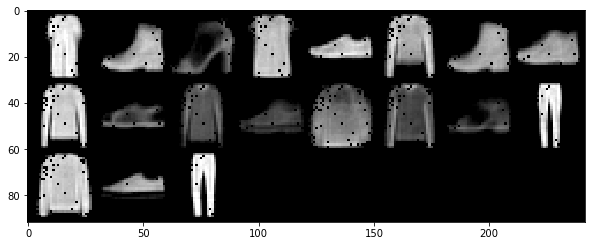

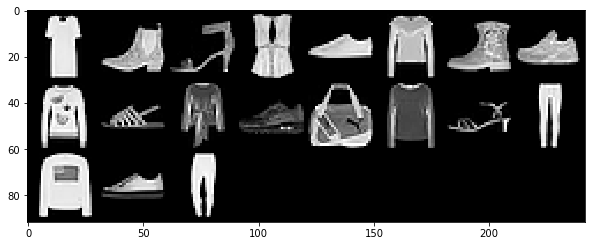

Epoch 4
-------------------------------
loss: 0.034060  [    0/60000]
loss: 0.032846  [ 2000/60000]
loss: 0.029287  [ 4000/60000]
loss: 0.030928  [ 6000/60000]
loss: 0.035637  [ 8000/60000]
loss: 0.032839  [10000/60000]
loss: 0.022392  [12000/60000]
loss: 0.030029  [14000/60000]
loss: 0.028122  [16000/60000]
loss: 0.028625  [18000/60000]
loss: 0.028614  [20000/60000]
loss: 0.030194  [22000/60000]
loss: 0.030133  [24000/60000]
loss: 0.023145  [26000/60000]
loss: 0.025595  [28000/60000]
loss: 0.025010  [30000/60000]
loss: 0.025825  [32000/60000]
loss: 0.029084  [34000/60000]
loss: 0.026619  [36000/60000]
loss: 0.025824  [38000/60000]
loss: 0.033863  [40000/60000]
loss: 0.026065  [42000/60000]
loss: 0.027539  [44000/60000]
loss: 0.028956  [46000/60000]
loss: 0.027586  [48000/60000]
loss: 0.033614  [50000/60000]
loss: 0.030132  [52000/60000]
loss: 0.032789  [54000/60000]
loss: 0.029327  [56000/60000]
loss: 0.028483  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


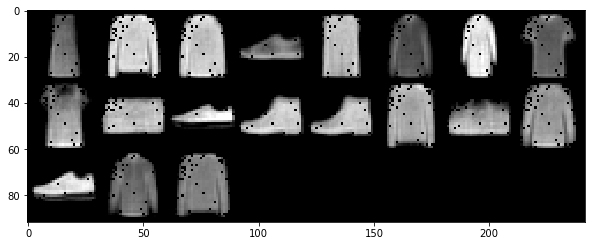

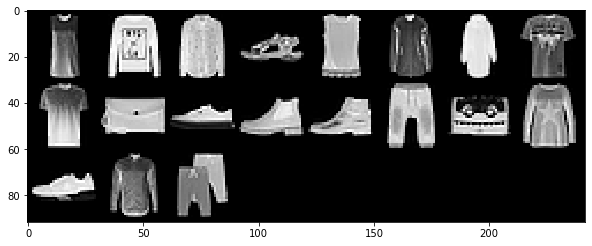

Epoch 5
-------------------------------
loss: 0.035256  [    0/60000]
loss: 0.027384  [ 2000/60000]
loss: 0.028907  [ 4000/60000]
loss: 0.028388  [ 6000/60000]
loss: 0.030026  [ 8000/60000]
loss: 0.030815  [10000/60000]
loss: 0.022639  [12000/60000]
loss: 0.026696  [14000/60000]
loss: 0.026019  [16000/60000]
loss: 0.025647  [18000/60000]
loss: 0.023991  [20000/60000]
loss: 0.028975  [22000/60000]
loss: 0.024594  [24000/60000]
loss: 0.028410  [26000/60000]
loss: 0.022159  [28000/60000]
loss: 0.034530  [30000/60000]
loss: 0.023504  [32000/60000]
loss: 0.023308  [34000/60000]
loss: 0.026284  [36000/60000]
loss: 0.032946  [38000/60000]
loss: 0.031572  [40000/60000]
loss: 0.021836  [42000/60000]
loss: 0.027742  [44000/60000]
loss: 0.020884  [46000/60000]
loss: 0.021634  [48000/60000]
loss: 0.025180  [50000/60000]
loss: 0.025904  [52000/60000]
loss: 0.025265  [54000/60000]
loss: 0.029393  [56000/60000]
loss: 0.029835  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


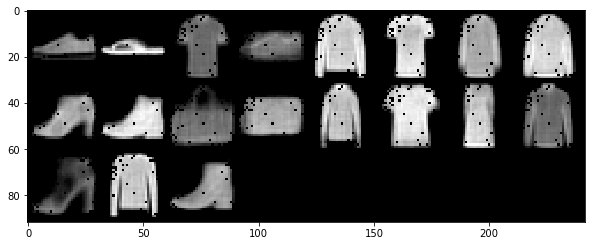

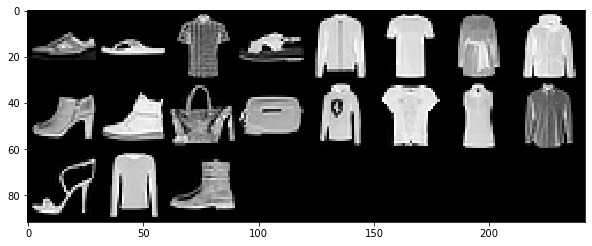

Epoch 6
-------------------------------
loss: 0.021054  [    0/60000]
loss: 0.023184  [ 2000/60000]
loss: 0.022062  [ 4000/60000]
loss: 0.027175  [ 6000/60000]
loss: 0.021638  [ 8000/60000]
loss: 0.027894  [10000/60000]
loss: 0.033709  [12000/60000]
loss: 0.023465  [14000/60000]
loss: 0.029766  [16000/60000]
loss: 0.023322  [18000/60000]
loss: 0.027227  [20000/60000]
loss: 0.024504  [22000/60000]
loss: 0.023582  [24000/60000]
loss: 0.018874  [26000/60000]
loss: 0.025584  [28000/60000]
loss: 0.022851  [30000/60000]
loss: 0.030582  [32000/60000]
loss: 0.023798  [34000/60000]
loss: 0.024023  [36000/60000]
loss: 0.023399  [38000/60000]
loss: 0.030700  [40000/60000]
loss: 0.023372  [42000/60000]
loss: 0.022106  [44000/60000]
loss: 0.030943  [46000/60000]
loss: 0.021335  [48000/60000]
loss: 0.029395  [50000/60000]
loss: 0.029763  [52000/60000]
loss: 0.028427  [54000/60000]
loss: 0.028166  [56000/60000]
loss: 0.023195  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


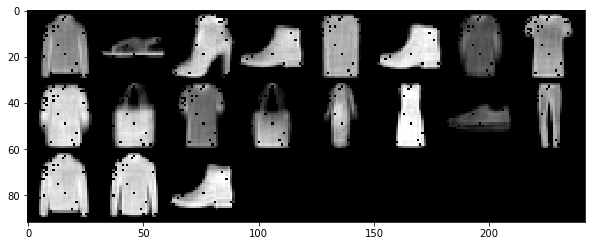

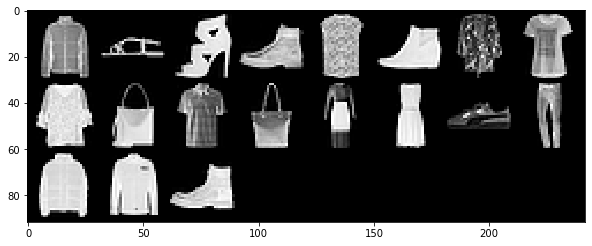

Epoch 7
-------------------------------
loss: 0.025378  [    0/60000]
loss: 0.024401  [ 2000/60000]
loss: 0.027090  [ 4000/60000]
loss: 0.025220  [ 6000/60000]
loss: 0.022628  [ 8000/60000]
loss: 0.026051  [10000/60000]
loss: 0.025213  [12000/60000]
loss: 0.023286  [14000/60000]
loss: 0.029799  [16000/60000]
loss: 0.024283  [18000/60000]
loss: 0.022422  [20000/60000]
loss: 0.028861  [22000/60000]
loss: 0.028137  [24000/60000]
loss: 0.022924  [26000/60000]
loss: 0.025808  [28000/60000]
loss: 0.025611  [30000/60000]
loss: 0.029543  [32000/60000]
loss: 0.020559  [34000/60000]
loss: 0.026421  [36000/60000]
loss: 0.024773  [38000/60000]
loss: 0.030364  [40000/60000]
loss: 0.024767  [42000/60000]
loss: 0.023114  [44000/60000]
loss: 0.026334  [46000/60000]
loss: 0.022024  [48000/60000]
loss: 0.024665  [50000/60000]
loss: 0.028681  [52000/60000]
loss: 0.021577  [54000/60000]
loss: 0.026708  [56000/60000]
loss: 0.023996  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


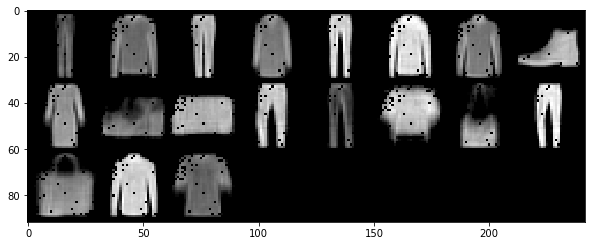

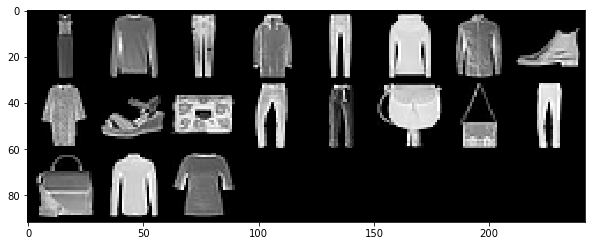

Epoch 8
-------------------------------
loss: 0.031895  [    0/60000]
loss: 0.028209  [ 2000/60000]
loss: 0.027662  [ 4000/60000]
loss: 0.027049  [ 6000/60000]
loss: 0.029013  [ 8000/60000]
loss: 0.022144  [10000/60000]
loss: 0.025314  [12000/60000]
loss: 0.024726  [14000/60000]
loss: 0.025141  [16000/60000]
loss: 0.018459  [18000/60000]
loss: 0.021444  [20000/60000]
loss: 0.023956  [22000/60000]
loss: 0.028628  [24000/60000]
loss: 0.024303  [26000/60000]
loss: 0.026596  [28000/60000]
loss: 0.027155  [30000/60000]
loss: 0.026925  [32000/60000]
loss: 0.028573  [34000/60000]
loss: 0.029556  [36000/60000]
loss: 0.024174  [38000/60000]
loss: 0.029469  [40000/60000]
loss: 0.025039  [42000/60000]
loss: 0.026329  [44000/60000]
loss: 0.025980  [46000/60000]
loss: 0.022778  [48000/60000]
loss: 0.027704  [50000/60000]
loss: 0.029671  [52000/60000]
loss: 0.023024  [54000/60000]
loss: 0.021338  [56000/60000]
loss: 0.021682  [58000/60000]


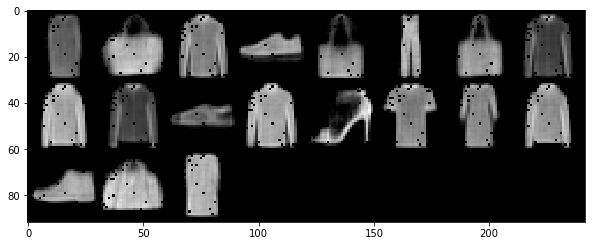

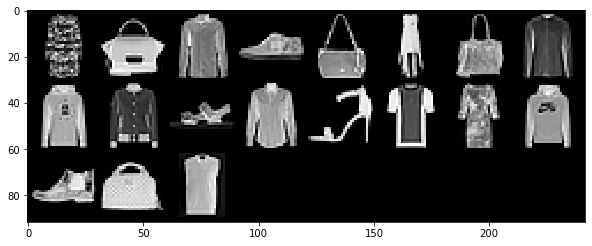

Epoch 9
-------------------------------
loss: 0.025304  [    0/60000]
loss: 0.024287  [ 2000/60000]
loss: 0.029313  [ 4000/60000]
loss: 0.025266  [ 6000/60000]
loss: 0.027315  [ 8000/60000]
loss: 0.025048  [10000/60000]
loss: 0.030731  [12000/60000]
loss: 0.023652  [14000/60000]
loss: 0.027232  [16000/60000]
loss: 0.020292  [18000/60000]
loss: 0.026228  [20000/60000]
loss: 0.022230  [22000/60000]
loss: 0.023608  [24000/60000]
loss: 0.025557  [26000/60000]
loss: 0.023935  [28000/60000]
loss: 0.025098  [30000/60000]
loss: 0.022888  [32000/60000]
loss: 0.025729  [34000/60000]
loss: 0.026705  [36000/60000]
loss: 0.023930  [38000/60000]
loss: 0.021936  [40000/60000]
loss: 0.026107  [42000/60000]
loss: 0.023152  [44000/60000]
loss: 0.026240  [46000/60000]
loss: 0.021213  [48000/60000]
loss: 0.034330  [50000/60000]
loss: 0.023427  [52000/60000]
loss: 0.023649  [54000/60000]
loss: 0.022452  [56000/60000]
loss: 0.022797  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


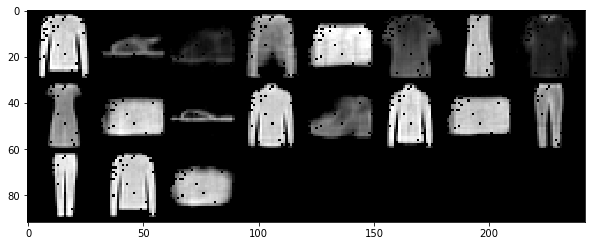

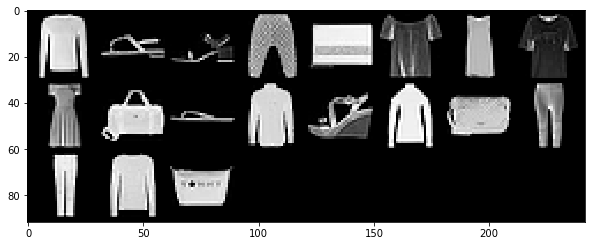

Epoch 10
-------------------------------
loss: 0.023576  [    0/60000]
loss: 0.029186  [ 2000/60000]
loss: 0.021372  [ 4000/60000]
loss: 0.020742  [ 6000/60000]
loss: 0.022265  [ 8000/60000]
loss: 0.022207  [10000/60000]
loss: 0.021140  [12000/60000]
loss: 0.026746  [14000/60000]
loss: 0.026350  [16000/60000]
loss: 0.021825  [18000/60000]
loss: 0.023388  [20000/60000]
loss: 0.026253  [22000/60000]
loss: 0.026019  [24000/60000]
loss: 0.026197  [26000/60000]
loss: 0.022887  [28000/60000]
loss: 0.020524  [30000/60000]
loss: 0.022532  [32000/60000]
loss: 0.022739  [34000/60000]
loss: 0.025715  [36000/60000]
loss: 0.025056  [38000/60000]
loss: 0.023100  [40000/60000]
loss: 0.021090  [42000/60000]
loss: 0.022591  [44000/60000]
loss: 0.023859  [46000/60000]
loss: 0.024683  [48000/60000]
loss: 0.022937  [50000/60000]
loss: 0.024772  [52000/60000]
loss: 0.020063  [54000/60000]
loss: 0.024558  [56000/60000]
loss: 0.026947  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


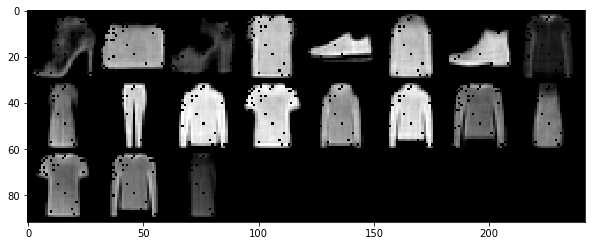

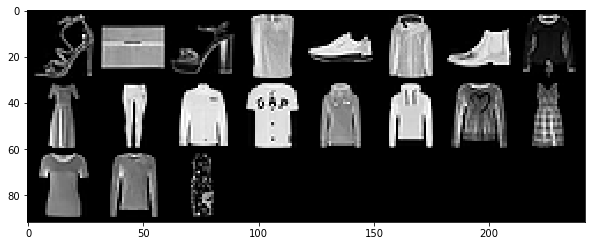

Epoch 11
-------------------------------
loss: 0.018467  [    0/60000]
loss: 0.031149  [ 2000/60000]
loss: 0.022506  [ 4000/60000]
loss: 0.020029  [ 6000/60000]
loss: 0.021655  [ 8000/60000]
loss: 0.028726  [10000/60000]
loss: 0.026683  [12000/60000]
loss: 0.026515  [14000/60000]
loss: 0.023883  [16000/60000]
loss: 0.022716  [18000/60000]
loss: 0.020458  [20000/60000]
loss: 0.020192  [22000/60000]
loss: 0.025270  [24000/60000]
loss: 0.024837  [26000/60000]
loss: 0.029189  [28000/60000]
loss: 0.032403  [30000/60000]
loss: 0.018371  [32000/60000]
loss: 0.023419  [34000/60000]
loss: 0.024040  [36000/60000]
loss: 0.023054  [38000/60000]
loss: 0.022205  [40000/60000]
loss: 0.028117  [42000/60000]
loss: 0.021075  [44000/60000]
loss: 0.026784  [46000/60000]
loss: 0.022800  [48000/60000]
loss: 0.026799  [50000/60000]
loss: 0.022490  [52000/60000]
loss: 0.025412  [54000/60000]
loss: 0.021645  [56000/60000]
loss: 0.027179  [58000/60000]


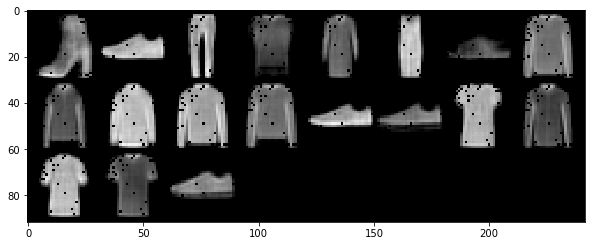

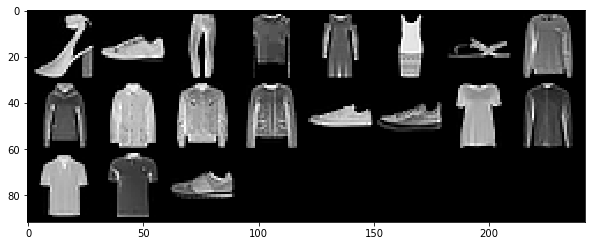

Epoch 12
-------------------------------
loss: 0.023322  [    0/60000]
loss: 0.020005  [ 2000/60000]
loss: 0.020314  [ 4000/60000]
loss: 0.029388  [ 6000/60000]
loss: 0.024259  [ 8000/60000]
loss: 0.025065  [10000/60000]
loss: 0.019326  [12000/60000]
loss: 0.024645  [14000/60000]
loss: 0.019306  [16000/60000]
loss: 0.025927  [18000/60000]
loss: 0.024100  [20000/60000]
loss: 0.020407  [22000/60000]
loss: 0.019021  [24000/60000]
loss: 0.022557  [26000/60000]
loss: 0.025768  [28000/60000]
loss: 0.020560  [30000/60000]
loss: 0.027895  [32000/60000]
loss: 0.024811  [34000/60000]
loss: 0.023873  [36000/60000]
loss: 0.024194  [38000/60000]
loss: 0.024393  [40000/60000]
loss: 0.019209  [42000/60000]
loss: 0.020802  [44000/60000]
loss: 0.018255  [46000/60000]
loss: 0.019352  [48000/60000]
loss: 0.022334  [50000/60000]
loss: 0.025974  [52000/60000]
loss: 0.020772  [54000/60000]
loss: 0.021313  [56000/60000]
loss: 0.033079  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


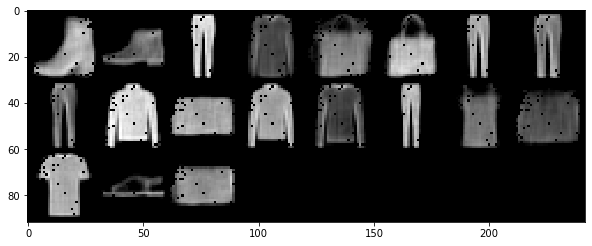

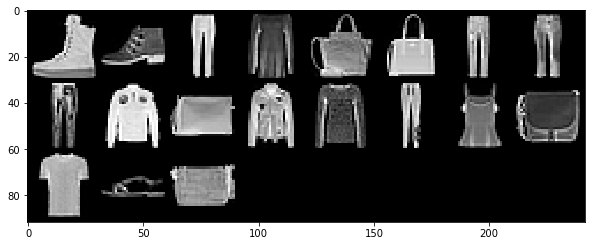

Epoch 13
-------------------------------
loss: 0.022265  [    0/60000]
loss: 0.017451  [ 2000/60000]
loss: 0.023229  [ 4000/60000]
loss: 0.023635  [ 6000/60000]
loss: 0.025277  [ 8000/60000]
loss: 0.024382  [10000/60000]
loss: 0.021704  [12000/60000]
loss: 0.018963  [14000/60000]
loss: 0.024145  [16000/60000]
loss: 0.019780  [18000/60000]
loss: 0.020668  [20000/60000]
loss: 0.022427  [22000/60000]
loss: 0.025930  [24000/60000]
loss: 0.020624  [26000/60000]
loss: 0.024596  [28000/60000]
loss: 0.016319  [30000/60000]
loss: 0.020708  [32000/60000]
loss: 0.026303  [34000/60000]
loss: 0.019630  [36000/60000]
loss: 0.021499  [38000/60000]
loss: 0.026976  [40000/60000]
loss: 0.025345  [42000/60000]
loss: 0.022611  [44000/60000]
loss: 0.026223  [46000/60000]
loss: 0.022832  [48000/60000]
loss: 0.027757  [50000/60000]
loss: 0.026637  [52000/60000]
loss: 0.025530  [54000/60000]
loss: 0.019185  [56000/60000]
loss: 0.020581  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


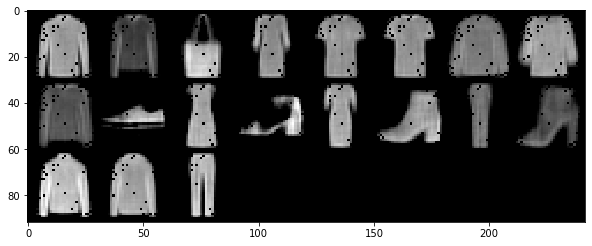

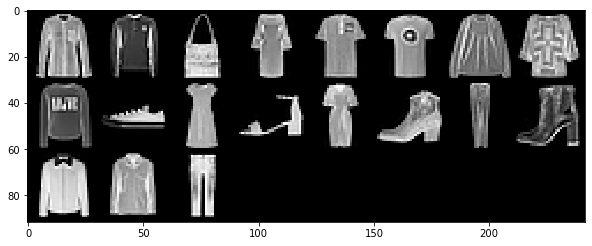

Epoch 14
-------------------------------
loss: 0.023956  [    0/60000]
loss: 0.021337  [ 2000/60000]
loss: 0.025904  [ 4000/60000]
loss: 0.024676  [ 6000/60000]
loss: 0.026619  [ 8000/60000]
loss: 0.022056  [10000/60000]
loss: 0.021847  [12000/60000]
loss: 0.021369  [14000/60000]
loss: 0.020373  [16000/60000]
loss: 0.025601  [18000/60000]
loss: 0.022009  [20000/60000]
loss: 0.023960  [22000/60000]
loss: 0.019851  [24000/60000]
loss: 0.023801  [26000/60000]
loss: 0.024724  [28000/60000]
loss: 0.017547  [30000/60000]
loss: 0.026178  [32000/60000]
loss: 0.021982  [34000/60000]
loss: 0.028675  [36000/60000]
loss: 0.022356  [38000/60000]
loss: 0.020443  [40000/60000]
loss: 0.021172  [42000/60000]
loss: 0.023647  [44000/60000]
loss: 0.027729  [46000/60000]
loss: 0.021210  [48000/60000]
loss: 0.020600  [50000/60000]
loss: 0.024517  [52000/60000]
loss: 0.028916  [54000/60000]
loss: 0.026357  [56000/60000]
loss: 0.024036  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


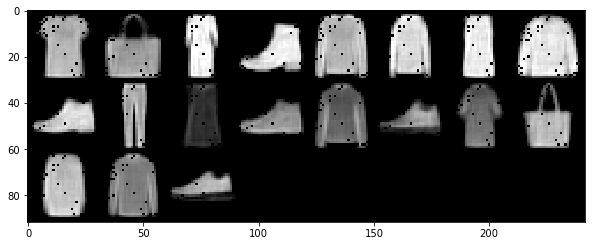

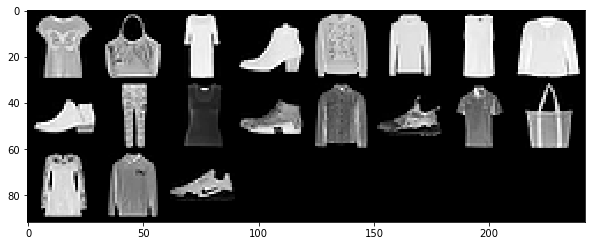

Epoch 15
-------------------------------
loss: 0.022814  [    0/60000]
loss: 0.026634  [ 2000/60000]
loss: 0.027422  [ 4000/60000]
loss: 0.020283  [ 6000/60000]
loss: 0.021997  [ 8000/60000]
loss: 0.021269  [10000/60000]
loss: 0.023428  [12000/60000]
loss: 0.023293  [14000/60000]
loss: 0.018492  [16000/60000]
loss: 0.024893  [18000/60000]
loss: 0.023426  [20000/60000]
loss: 0.021715  [22000/60000]
loss: 0.024915  [24000/60000]
loss: 0.019301  [26000/60000]
loss: 0.021287  [28000/60000]
loss: 0.021748  [30000/60000]
loss: 0.021278  [32000/60000]
loss: 0.023577  [34000/60000]
loss: 0.022058  [36000/60000]
loss: 0.019562  [38000/60000]
loss: 0.025405  [40000/60000]
loss: 0.021455  [42000/60000]
loss: 0.021883  [44000/60000]
loss: 0.019739  [46000/60000]
loss: 0.021858  [48000/60000]
loss: 0.016807  [50000/60000]
loss: 0.021063  [52000/60000]
loss: 0.019996  [54000/60000]
loss: 0.023567  [56000/60000]
loss: 0.028701  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


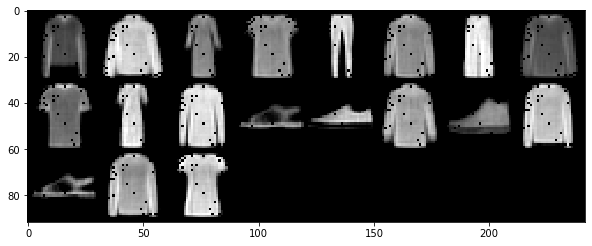

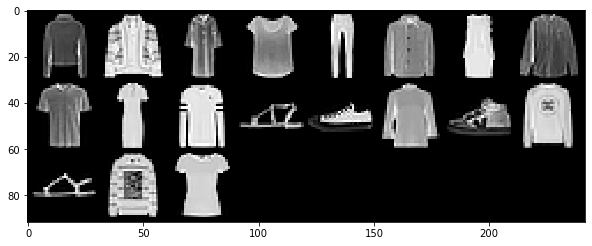

Epoch 16
-------------------------------
loss: 0.028799  [    0/60000]
loss: 0.026897  [ 2000/60000]
loss: 0.018647  [ 4000/60000]
loss: 0.022400  [ 6000/60000]
loss: 0.024144  [ 8000/60000]
loss: 0.022988  [10000/60000]
loss: 0.022509  [12000/60000]
loss: 0.019457  [14000/60000]
loss: 0.018453  [16000/60000]
loss: 0.018695  [18000/60000]
loss: 0.022941  [20000/60000]
loss: 0.015517  [22000/60000]
loss: 0.026541  [24000/60000]
loss: 0.024048  [26000/60000]
loss: 0.020284  [28000/60000]
loss: 0.017455  [30000/60000]
loss: 0.019456  [32000/60000]
loss: 0.020900  [34000/60000]
loss: 0.019948  [36000/60000]
loss: 0.024803  [38000/60000]
loss: 0.020237  [40000/60000]
loss: 0.019256  [42000/60000]
loss: 0.020648  [44000/60000]
loss: 0.022662  [46000/60000]
loss: 0.019323  [48000/60000]
loss: 0.023933  [50000/60000]
loss: 0.024780  [52000/60000]
loss: 0.019716  [54000/60000]
loss: 0.016630  [56000/60000]
loss: 0.020769  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


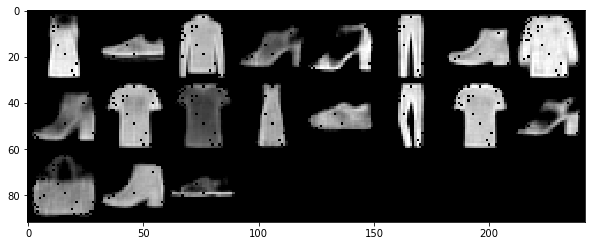

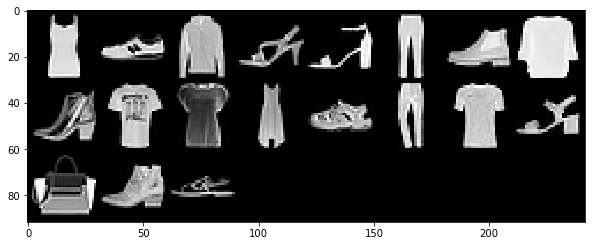

Epoch 17
-------------------------------
loss: 0.019580  [    0/60000]
loss: 0.021197  [ 2000/60000]
loss: 0.023372  [ 4000/60000]
loss: 0.020428  [ 6000/60000]
loss: 0.022693  [ 8000/60000]
loss: 0.024833  [10000/60000]
loss: 0.020473  [12000/60000]
loss: 0.020393  [14000/60000]
loss: 0.022313  [16000/60000]
loss: 0.021555  [18000/60000]
loss: 0.023008  [20000/60000]
loss: 0.020521  [22000/60000]
loss: 0.024333  [24000/60000]
loss: 0.023163  [26000/60000]
loss: 0.022619  [28000/60000]
loss: 0.022277  [30000/60000]
loss: 0.021637  [32000/60000]
loss: 0.019375  [34000/60000]
loss: 0.021309  [36000/60000]
loss: 0.017431  [38000/60000]
loss: 0.021916  [40000/60000]
loss: 0.022885  [42000/60000]
loss: 0.020103  [44000/60000]
loss: 0.020657  [46000/60000]
loss: 0.018510  [48000/60000]
loss: 0.026156  [50000/60000]
loss: 0.018438  [52000/60000]
loss: 0.020145  [54000/60000]
loss: 0.022538  [56000/60000]
loss: 0.019520  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


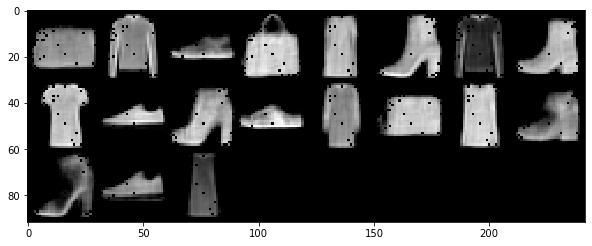

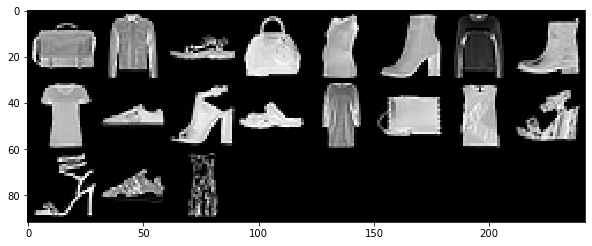

Epoch 18
-------------------------------
loss: 0.019089  [    0/60000]
loss: 0.022652  [ 2000/60000]
loss: 0.024257  [ 4000/60000]
loss: 0.022798  [ 6000/60000]
loss: 0.017988  [ 8000/60000]
loss: 0.024448  [10000/60000]
loss: 0.020788  [12000/60000]
loss: 0.022102  [14000/60000]
loss: 0.025712  [16000/60000]
loss: 0.017707  [18000/60000]
loss: 0.022769  [20000/60000]
loss: 0.020695  [22000/60000]
loss: 0.018510  [24000/60000]
loss: 0.022032  [26000/60000]
loss: 0.019966  [28000/60000]
loss: 0.017801  [30000/60000]
loss: 0.027880  [32000/60000]
loss: 0.019788  [34000/60000]
loss: 0.023270  [36000/60000]
loss: 0.023256  [38000/60000]
loss: 0.021230  [40000/60000]
loss: 0.021153  [42000/60000]
loss: 0.023424  [44000/60000]
loss: 0.022302  [46000/60000]
loss: 0.019543  [48000/60000]
loss: 0.017300  [50000/60000]
loss: 0.021750  [52000/60000]
loss: 0.022123  [54000/60000]
loss: 0.019410  [56000/60000]
loss: 0.027939  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


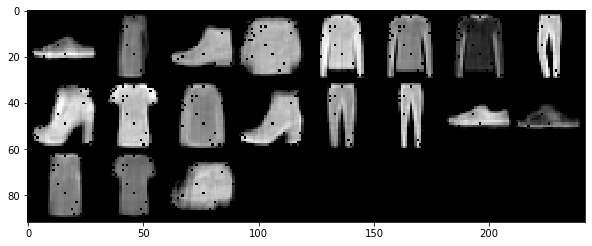

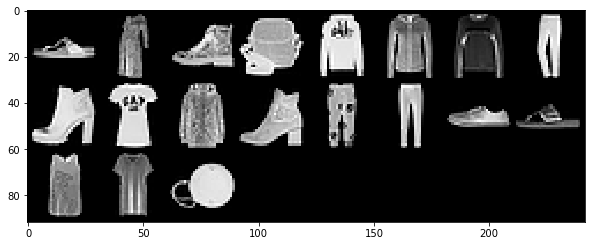

Epoch 19
-------------------------------
loss: 0.021250  [    0/60000]
loss: 0.016875  [ 2000/60000]
loss: 0.023632  [ 4000/60000]
loss: 0.020441  [ 6000/60000]
loss: 0.025433  [ 8000/60000]
loss: 0.019460  [10000/60000]
loss: 0.023267  [12000/60000]
loss: 0.022114  [14000/60000]
loss: 0.022654  [16000/60000]
loss: 0.020916  [18000/60000]
loss: 0.019740  [20000/60000]
loss: 0.017379  [22000/60000]
loss: 0.020337  [24000/60000]
loss: 0.020316  [26000/60000]
loss: 0.022633  [28000/60000]
loss: 0.016792  [30000/60000]
loss: 0.018153  [32000/60000]
loss: 0.021913  [34000/60000]
loss: 0.021887  [36000/60000]
loss: 0.021107  [38000/60000]
loss: 0.024988  [40000/60000]
loss: 0.023238  [42000/60000]
loss: 0.020664  [44000/60000]
loss: 0.026457  [46000/60000]
loss: 0.025328  [48000/60000]
loss: 0.021554  [50000/60000]
loss: 0.020909  [52000/60000]
loss: 0.019226  [54000/60000]
loss: 0.019272  [56000/60000]
loss: 0.019421  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


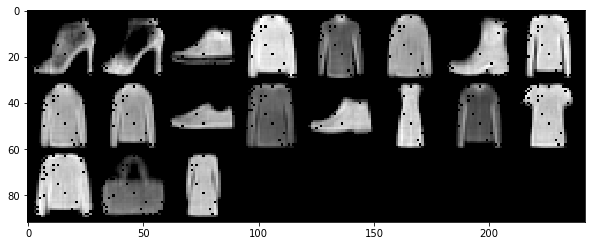

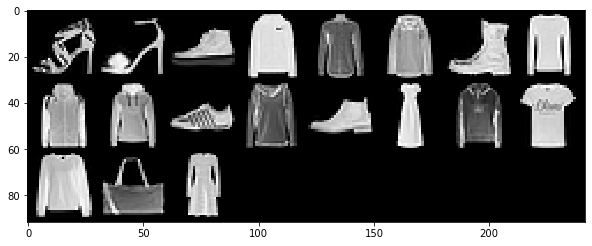

Epoch 20
-------------------------------
loss: 0.021731  [    0/60000]
loss: 0.021480  [ 2000/60000]
loss: 0.021695  [ 4000/60000]
loss: 0.022534  [ 6000/60000]
loss: 0.023293  [ 8000/60000]
loss: 0.025424  [10000/60000]
loss: 0.021013  [12000/60000]
loss: 0.019040  [14000/60000]
loss: 0.023896  [16000/60000]
loss: 0.023257  [18000/60000]
loss: 0.020986  [20000/60000]
loss: 0.016583  [22000/60000]
loss: 0.017099  [24000/60000]
loss: 0.020012  [26000/60000]
loss: 0.018128  [28000/60000]
loss: 0.023939  [30000/60000]
loss: 0.020062  [32000/60000]
loss: 0.017673  [34000/60000]
loss: 0.023062  [36000/60000]
loss: 0.026980  [38000/60000]
loss: 0.020066  [40000/60000]
loss: 0.023125  [42000/60000]
loss: 0.021361  [44000/60000]
loss: 0.018504  [46000/60000]
loss: 0.024693  [48000/60000]
loss: 0.020919  [50000/60000]
loss: 0.015643  [52000/60000]
loss: 0.021666  [54000/60000]
loss: 0.018729  [56000/60000]
loss: 0.023030  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


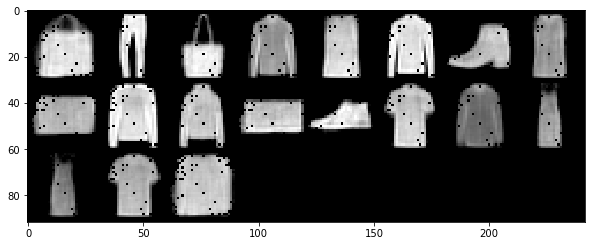

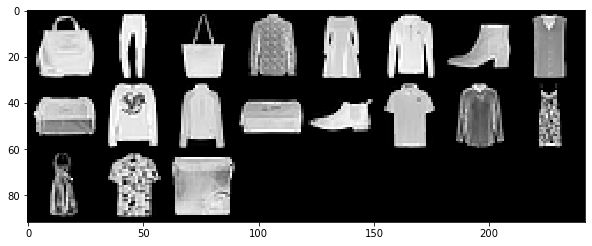

Epoch 21
-------------------------------
loss: 0.022299  [    0/60000]
loss: 0.017752  [ 2000/60000]
loss: 0.020800  [ 4000/60000]
loss: 0.023463  [ 6000/60000]
loss: 0.020896  [ 8000/60000]
loss: 0.022061  [10000/60000]
loss: 0.019739  [12000/60000]
loss: 0.022727  [14000/60000]
loss: 0.019066  [16000/60000]
loss: 0.021918  [18000/60000]
loss: 0.020450  [20000/60000]
loss: 0.022592  [22000/60000]
loss: 0.022077  [24000/60000]
loss: 0.021726  [26000/60000]
loss: 0.021007  [28000/60000]
loss: 0.018010  [30000/60000]
loss: 0.024713  [32000/60000]
loss: 0.022340  [34000/60000]
loss: 0.024855  [36000/60000]
loss: 0.021635  [38000/60000]
loss: 0.023974  [40000/60000]
loss: 0.018750  [42000/60000]
loss: 0.023781  [44000/60000]
loss: 0.022866  [46000/60000]
loss: 0.022676  [48000/60000]
loss: 0.024581  [50000/60000]
loss: 0.017801  [52000/60000]
loss: 0.026907  [54000/60000]
loss: 0.020367  [56000/60000]
loss: 0.017473  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


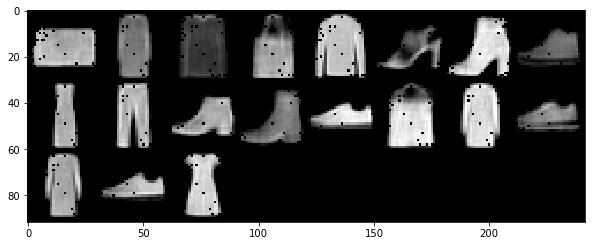

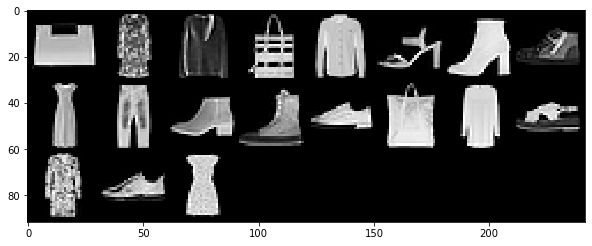

Epoch 22
-------------------------------
loss: 0.020257  [    0/60000]
loss: 0.023136  [ 2000/60000]
loss: 0.020322  [ 4000/60000]
loss: 0.017327  [ 6000/60000]
loss: 0.027206  [ 8000/60000]
loss: 0.020209  [10000/60000]
loss: 0.021790  [12000/60000]
loss: 0.022951  [14000/60000]
loss: 0.024600  [16000/60000]
loss: 0.023938  [18000/60000]
loss: 0.023642  [20000/60000]
loss: 0.022046  [22000/60000]
loss: 0.022831  [24000/60000]
loss: 0.018650  [26000/60000]
loss: 0.023152  [28000/60000]
loss: 0.020257  [30000/60000]
loss: 0.018411  [32000/60000]
loss: 0.017564  [34000/60000]
loss: 0.023547  [36000/60000]
loss: 0.020564  [38000/60000]
loss: 0.021148  [40000/60000]
loss: 0.019571  [42000/60000]
loss: 0.018949  [44000/60000]
loss: 0.017199  [46000/60000]
loss: 0.020427  [48000/60000]
loss: 0.019722  [50000/60000]
loss: 0.020441  [52000/60000]
loss: 0.029056  [54000/60000]
loss: 0.021677  [56000/60000]
loss: 0.022960  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


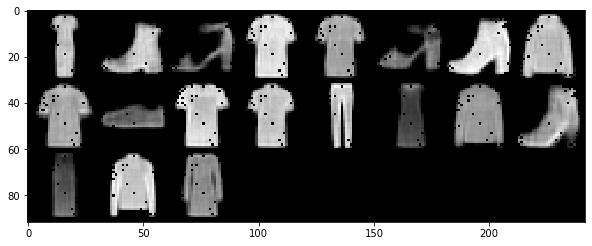

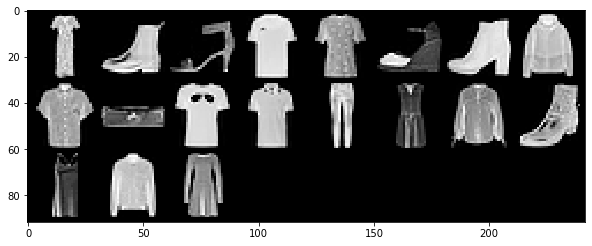

Epoch 23
-------------------------------
loss: 0.017747  [    0/60000]
loss: 0.019029  [ 2000/60000]
loss: 0.028038  [ 4000/60000]
loss: 0.018618  [ 6000/60000]
loss: 0.021730  [ 8000/60000]
loss: 0.022938  [10000/60000]
loss: 0.021655  [12000/60000]
loss: 0.027780  [14000/60000]
loss: 0.024875  [16000/60000]
loss: 0.018542  [18000/60000]
loss: 0.018901  [20000/60000]
loss: 0.020263  [22000/60000]
loss: 0.017400  [24000/60000]
loss: 0.028894  [26000/60000]
loss: 0.018588  [28000/60000]
loss: 0.018474  [30000/60000]
loss: 0.019276  [32000/60000]
loss: 0.020650  [34000/60000]
loss: 0.020782  [36000/60000]
loss: 0.019038  [38000/60000]
loss: 0.022182  [40000/60000]
loss: 0.017848  [42000/60000]
loss: 0.022550  [44000/60000]
loss: 0.017781  [46000/60000]
loss: 0.025300  [48000/60000]
loss: 0.017864  [50000/60000]
loss: 0.018689  [52000/60000]
loss: 0.015455  [54000/60000]
loss: 0.020335  [56000/60000]
loss: 0.018407  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


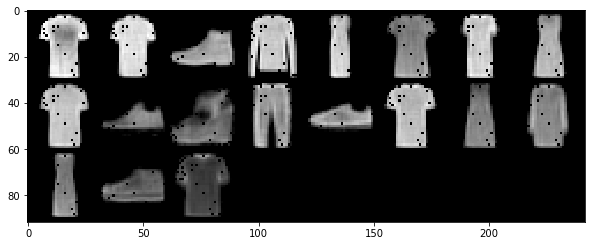

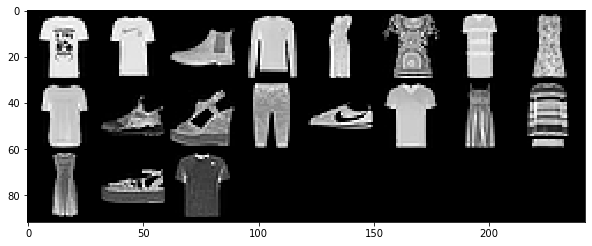

Epoch 24
-------------------------------
loss: 0.024060  [    0/60000]
loss: 0.023420  [ 2000/60000]
loss: 0.024757  [ 4000/60000]
loss: 0.019553  [ 6000/60000]
loss: 0.019786  [ 8000/60000]
loss: 0.023212  [10000/60000]
loss: 0.020194  [12000/60000]
loss: 0.020397  [14000/60000]
loss: 0.025528  [16000/60000]
loss: 0.022839  [18000/60000]
loss: 0.018276  [20000/60000]
loss: 0.019497  [22000/60000]
loss: 0.025640  [24000/60000]
loss: 0.018714  [26000/60000]
loss: 0.019638  [28000/60000]
loss: 0.021050  [30000/60000]
loss: 0.022744  [32000/60000]
loss: 0.025154  [34000/60000]
loss: 0.022396  [36000/60000]
loss: 0.021865  [38000/60000]
loss: 0.019257  [40000/60000]
loss: 0.021982  [42000/60000]
loss: 0.018208  [44000/60000]
loss: 0.020531  [46000/60000]
loss: 0.019389  [48000/60000]
loss: 0.019049  [50000/60000]
loss: 0.020885  [52000/60000]
loss: 0.020687  [54000/60000]
loss: 0.017557  [56000/60000]
loss: 0.017784  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


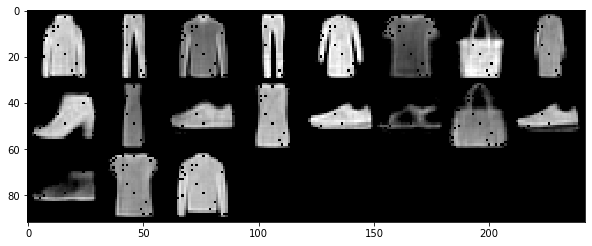

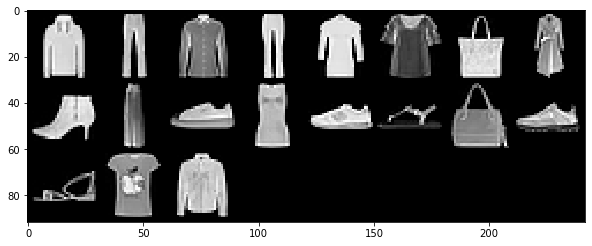

Epoch 25
-------------------------------
loss: 0.021917  [    0/60000]
loss: 0.020263  [ 2000/60000]
loss: 0.024755  [ 4000/60000]
loss: 0.022547  [ 6000/60000]
loss: 0.018531  [ 8000/60000]
loss: 0.022593  [10000/60000]
loss: 0.023106  [12000/60000]
loss: 0.023882  [14000/60000]
loss: 0.015740  [16000/60000]
loss: 0.018511  [18000/60000]
loss: 0.020694  [20000/60000]
loss: 0.020990  [22000/60000]
loss: 0.023040  [24000/60000]
loss: 0.016919  [26000/60000]
loss: 0.022353  [28000/60000]
loss: 0.018557  [30000/60000]
loss: 0.019328  [32000/60000]
loss: 0.018806  [34000/60000]
loss: 0.023588  [36000/60000]
loss: 0.018188  [38000/60000]
loss: 0.021520  [40000/60000]
loss: 0.021411  [42000/60000]
loss: 0.022975  [44000/60000]
loss: 0.022445  [46000/60000]
loss: 0.021001  [48000/60000]
loss: 0.020139  [50000/60000]
loss: 0.019220  [52000/60000]
loss: 0.022745  [54000/60000]
loss: 0.020113  [56000/60000]
loss: 0.021176  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


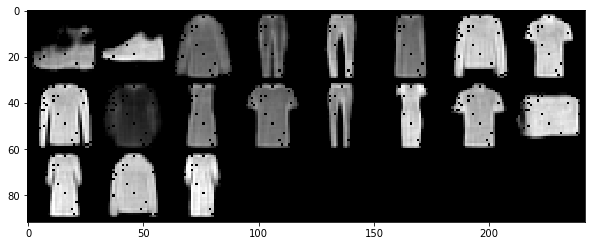

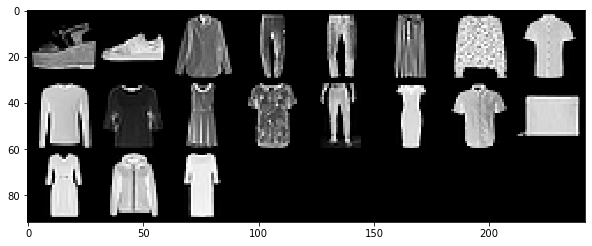

Epoch 26
-------------------------------
loss: 0.023705  [    0/60000]
loss: 0.021389  [ 2000/60000]
loss: 0.025313  [ 4000/60000]
loss: 0.024878  [ 6000/60000]
loss: 0.021656  [ 8000/60000]
loss: 0.020917  [10000/60000]
loss: 0.019293  [12000/60000]
loss: 0.022937  [14000/60000]
loss: 0.019205  [16000/60000]
loss: 0.024545  [18000/60000]
loss: 0.018798  [20000/60000]
loss: 0.022756  [22000/60000]
loss: 0.016691  [24000/60000]
loss: 0.023425  [26000/60000]
loss: 0.020392  [28000/60000]
loss: 0.018741  [30000/60000]
loss: 0.021957  [32000/60000]
loss: 0.022431  [34000/60000]
loss: 0.020052  [36000/60000]
loss: 0.027324  [38000/60000]
loss: 0.023297  [40000/60000]
loss: 0.027831  [42000/60000]
loss: 0.022375  [44000/60000]
loss: 0.020746  [46000/60000]
loss: 0.018230  [48000/60000]
loss: 0.022312  [50000/60000]
loss: 0.021101  [52000/60000]
loss: 0.022164  [54000/60000]
loss: 0.023092  [56000/60000]
loss: 0.022069  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


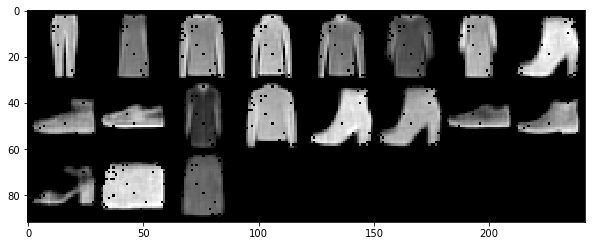

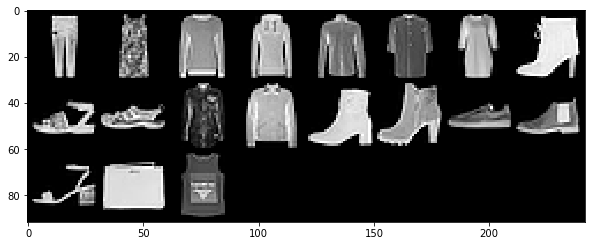

Epoch 27
-------------------------------
loss: 0.018842  [    0/60000]
loss: 0.017427  [ 2000/60000]
loss: 0.018310  [ 4000/60000]
loss: 0.019344  [ 6000/60000]
loss: 0.023484  [ 8000/60000]
loss: 0.020453  [10000/60000]
loss: 0.018942  [12000/60000]
loss: 0.019159  [14000/60000]
loss: 0.023246  [16000/60000]
loss: 0.019237  [18000/60000]
loss: 0.023108  [20000/60000]
loss: 0.021501  [22000/60000]
loss: 0.022873  [24000/60000]
loss: 0.021025  [26000/60000]
loss: 0.021732  [28000/60000]
loss: 0.016686  [30000/60000]
loss: 0.020397  [32000/60000]
loss: 0.020218  [34000/60000]
loss: 0.021383  [36000/60000]
loss: 0.023595  [38000/60000]
loss: 0.020614  [40000/60000]
loss: 0.021944  [42000/60000]
loss: 0.022082  [44000/60000]
loss: 0.021277  [46000/60000]
loss: 0.022535  [48000/60000]
loss: 0.020621  [50000/60000]
loss: 0.022609  [52000/60000]
loss: 0.018962  [54000/60000]
loss: 0.022153  [56000/60000]
loss: 0.021334  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


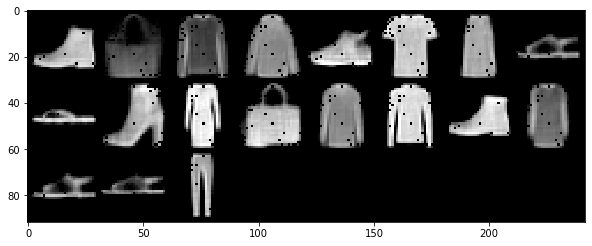

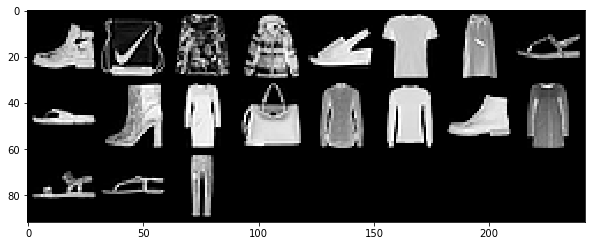

Epoch 28
-------------------------------
loss: 0.019269  [    0/60000]
loss: 0.017227  [ 2000/60000]
loss: 0.022898  [ 4000/60000]
loss: 0.022468  [ 6000/60000]
loss: 0.024100  [ 8000/60000]
loss: 0.017827  [10000/60000]
loss: 0.020717  [12000/60000]
loss: 0.020021  [14000/60000]
loss: 0.017899  [16000/60000]
loss: 0.018965  [18000/60000]
loss: 0.017631  [20000/60000]
loss: 0.019743  [22000/60000]
loss: 0.017133  [24000/60000]
loss: 0.021560  [26000/60000]
loss: 0.019704  [28000/60000]
loss: 0.023693  [30000/60000]
loss: 0.021161  [32000/60000]
loss: 0.019415  [34000/60000]
loss: 0.020706  [36000/60000]
loss: 0.018045  [38000/60000]
loss: 0.018719  [40000/60000]
loss: 0.020371  [42000/60000]
loss: 0.022478  [44000/60000]
loss: 0.023063  [46000/60000]
loss: 0.020904  [48000/60000]
loss: 0.020953  [50000/60000]
loss: 0.021850  [52000/60000]
loss: 0.023385  [54000/60000]
loss: 0.019934  [56000/60000]
loss: 0.025322  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


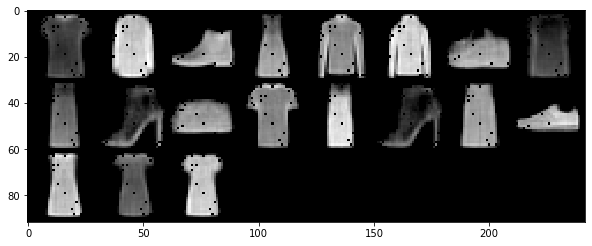

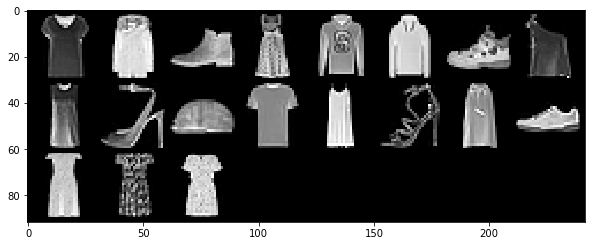

Epoch 29
-------------------------------
loss: 0.020544  [    0/60000]
loss: 0.023939  [ 2000/60000]
loss: 0.016221  [ 4000/60000]
loss: 0.022914  [ 6000/60000]
loss: 0.022517  [ 8000/60000]
loss: 0.021368  [10000/60000]
loss: 0.020082  [12000/60000]
loss: 0.020604  [14000/60000]
loss: 0.025604  [16000/60000]
loss: 0.020283  [18000/60000]
loss: 0.017833  [20000/60000]
loss: 0.024912  [22000/60000]
loss: 0.019371  [24000/60000]
loss: 0.022541  [26000/60000]
loss: 0.018577  [28000/60000]
loss: 0.020352  [30000/60000]
loss: 0.021004  [32000/60000]
loss: 0.025274  [34000/60000]
loss: 0.021456  [36000/60000]
loss: 0.021319  [38000/60000]
loss: 0.020424  [40000/60000]
loss: 0.024907  [42000/60000]
loss: 0.020094  [44000/60000]
loss: 0.016684  [46000/60000]
loss: 0.022386  [48000/60000]
loss: 0.019849  [50000/60000]
loss: 0.019935  [52000/60000]
loss: 0.022122  [54000/60000]
loss: 0.019469  [56000/60000]
loss: 0.026282  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


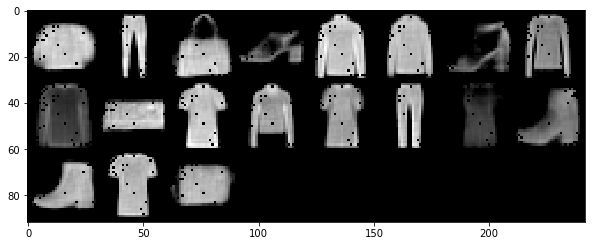

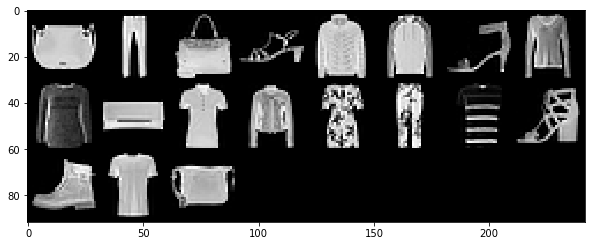

Epoch 30
-------------------------------
loss: 0.021801  [    0/60000]
loss: 0.020059  [ 2000/60000]
loss: 0.016526  [ 4000/60000]
loss: 0.023063  [ 6000/60000]
loss: 0.024389  [ 8000/60000]
loss: 0.017959  [10000/60000]
loss: 0.019572  [12000/60000]
loss: 0.013984  [14000/60000]
loss: 0.023156  [16000/60000]
loss: 0.021960  [18000/60000]
loss: 0.018441  [20000/60000]
loss: 0.020258  [22000/60000]
loss: 0.017454  [24000/60000]
loss: 0.018707  [26000/60000]
loss: 0.017811  [28000/60000]
loss: 0.022712  [30000/60000]
loss: 0.022148  [32000/60000]
loss: 0.021792  [34000/60000]
loss: 0.019071  [36000/60000]
loss: 0.021924  [38000/60000]
loss: 0.018382  [40000/60000]
loss: 0.026592  [42000/60000]
loss: 0.020494  [44000/60000]
loss: 0.022102  [46000/60000]
loss: 0.022176  [48000/60000]
loss: 0.019583  [50000/60000]
loss: 0.022791  [52000/60000]
loss: 0.017540  [54000/60000]
loss: 0.020371  [56000/60000]
loss: 0.017451  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


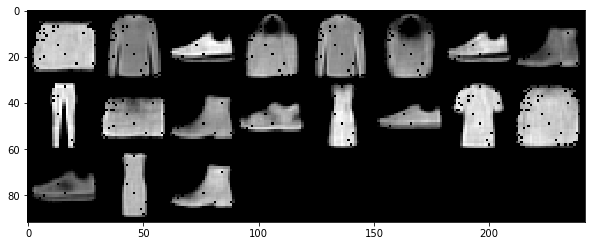

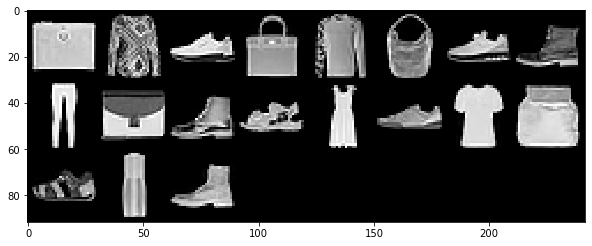

Epoch 31
-------------------------------
loss: 0.018855  [    0/60000]
loss: 0.022475  [ 2000/60000]
loss: 0.019305  [ 4000/60000]
loss: 0.016545  [ 6000/60000]
loss: 0.021712  [ 8000/60000]
loss: 0.020113  [10000/60000]
loss: 0.020711  [12000/60000]
loss: 0.016972  [14000/60000]
loss: 0.019864  [16000/60000]
loss: 0.021393  [18000/60000]
loss: 0.016756  [20000/60000]
loss: 0.021035  [22000/60000]
loss: 0.018081  [24000/60000]
loss: 0.020015  [26000/60000]
loss: 0.017792  [28000/60000]
loss: 0.023753  [30000/60000]
loss: 0.018171  [32000/60000]
loss: 0.016624  [34000/60000]
loss: 0.020484  [36000/60000]
loss: 0.019466  [38000/60000]
loss: 0.022712  [40000/60000]
loss: 0.020414  [42000/60000]
loss: 0.023010  [44000/60000]
loss: 0.017713  [46000/60000]
loss: 0.019050  [48000/60000]
loss: 0.021550  [50000/60000]
loss: 0.021470  [52000/60000]
loss: 0.019555  [54000/60000]
loss: 0.022807  [56000/60000]
loss: 0.024282  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


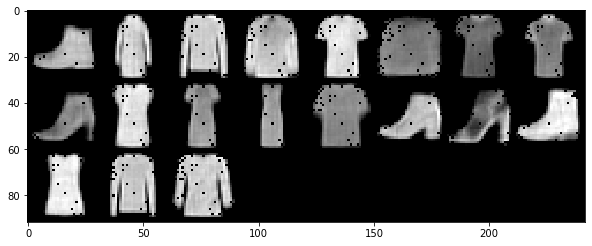

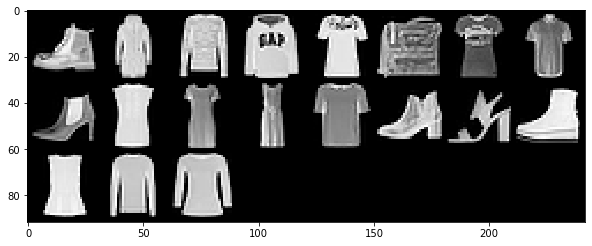

Epoch 32
-------------------------------
loss: 0.018675  [    0/60000]
loss: 0.023696  [ 2000/60000]
loss: 0.022529  [ 4000/60000]
loss: 0.018647  [ 6000/60000]
loss: 0.017409  [ 8000/60000]
loss: 0.021592  [10000/60000]
loss: 0.020956  [12000/60000]
loss: 0.020675  [14000/60000]
loss: 0.020307  [16000/60000]
loss: 0.018763  [18000/60000]
loss: 0.018096  [20000/60000]
loss: 0.021311  [22000/60000]
loss: 0.022746  [24000/60000]
loss: 0.019683  [26000/60000]
loss: 0.019287  [28000/60000]
loss: 0.019753  [30000/60000]
loss: 0.022590  [32000/60000]
loss: 0.020964  [34000/60000]
loss: 0.018508  [36000/60000]
loss: 0.021186  [38000/60000]
loss: 0.019899  [40000/60000]
loss: 0.016175  [42000/60000]
loss: 0.024695  [44000/60000]
loss: 0.021037  [46000/60000]
loss: 0.022291  [48000/60000]
loss: 0.017703  [50000/60000]
loss: 0.021202  [52000/60000]
loss: 0.024477  [54000/60000]
loss: 0.017704  [56000/60000]
loss: 0.018905  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


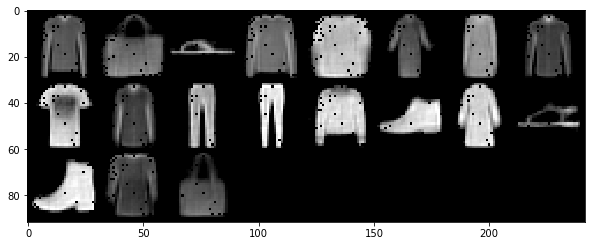

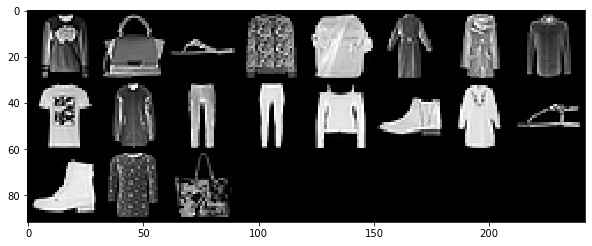

Epoch 33
-------------------------------
loss: 0.020905  [    0/60000]
loss: 0.020290  [ 2000/60000]
loss: 0.022538  [ 4000/60000]
loss: 0.021705  [ 6000/60000]
loss: 0.023228  [ 8000/60000]
loss: 0.015865  [10000/60000]
loss: 0.027602  [12000/60000]
loss: 0.020880  [14000/60000]
loss: 0.020082  [16000/60000]
loss: 0.023972  [18000/60000]
loss: 0.020381  [20000/60000]
loss: 0.018778  [22000/60000]
loss: 0.021601  [24000/60000]
loss: 0.019104  [26000/60000]
loss: 0.021478  [28000/60000]
loss: 0.020523  [30000/60000]
loss: 0.019963  [32000/60000]
loss: 0.020592  [34000/60000]
loss: 0.021212  [36000/60000]
loss: 0.017867  [38000/60000]
loss: 0.022426  [40000/60000]
loss: 0.020375  [42000/60000]
loss: 0.017016  [44000/60000]
loss: 0.016937  [46000/60000]
loss: 0.024881  [48000/60000]
loss: 0.024601  [50000/60000]
loss: 0.019427  [52000/60000]
loss: 0.020814  [54000/60000]
loss: 0.027241  [56000/60000]
loss: 0.021794  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


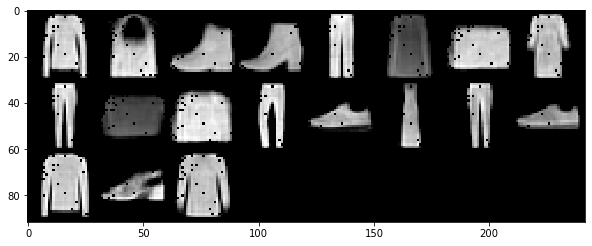

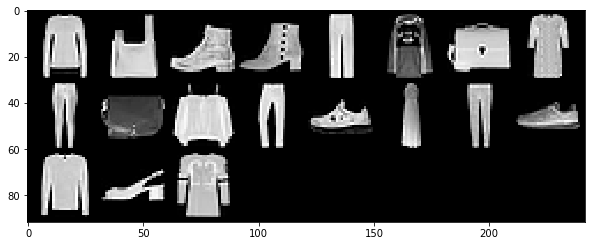

Epoch 34
-------------------------------
loss: 0.017030  [    0/60000]
loss: 0.022073  [ 2000/60000]
loss: 0.020186  [ 4000/60000]
loss: 0.020750  [ 6000/60000]
loss: 0.021708  [ 8000/60000]
loss: 0.017122  [10000/60000]
loss: 0.022898  [12000/60000]
loss: 0.019677  [14000/60000]
loss: 0.022013  [16000/60000]
loss: 0.015424  [18000/60000]
loss: 0.021292  [20000/60000]
loss: 0.023948  [22000/60000]
loss: 0.021393  [24000/60000]
loss: 0.018221  [26000/60000]
loss: 0.018375  [28000/60000]
loss: 0.021687  [30000/60000]
loss: 0.020502  [32000/60000]
loss: 0.025205  [34000/60000]
loss: 0.016993  [36000/60000]
loss: 0.022503  [38000/60000]
loss: 0.019727  [40000/60000]
loss: 0.017471  [42000/60000]
loss: 0.021432  [44000/60000]
loss: 0.018624  [46000/60000]
loss: 0.023352  [48000/60000]
loss: 0.019384  [50000/60000]
loss: 0.016160  [52000/60000]
loss: 0.022673  [54000/60000]
loss: 0.022241  [56000/60000]
loss: 0.020617  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


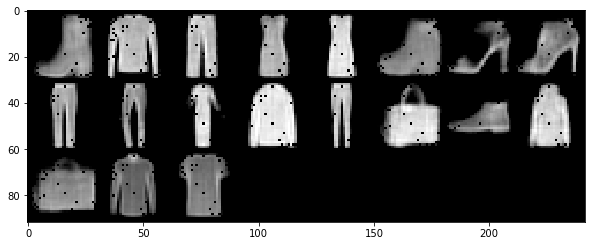

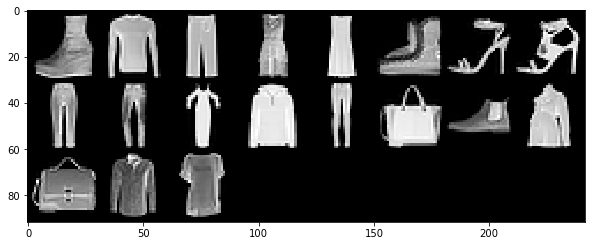

Epoch 35
-------------------------------
loss: 0.020993  [    0/60000]
loss: 0.020889  [ 2000/60000]
loss: 0.022460  [ 4000/60000]
loss: 0.022561  [ 6000/60000]
loss: 0.023659  [ 8000/60000]
loss: 0.020735  [10000/60000]
loss: 0.019977  [12000/60000]
loss: 0.021619  [14000/60000]
loss: 0.020136  [16000/60000]
loss: 0.021934  [18000/60000]
loss: 0.024822  [20000/60000]
loss: 0.021750  [22000/60000]
loss: 0.020178  [24000/60000]
loss: 0.018983  [26000/60000]
loss: 0.022783  [28000/60000]
loss: 0.021040  [30000/60000]
loss: 0.025416  [32000/60000]
loss: 0.020936  [34000/60000]
loss: 0.021624  [36000/60000]
loss: 0.020638  [38000/60000]
loss: 0.022186  [40000/60000]
loss: 0.021651  [42000/60000]
loss: 0.021987  [44000/60000]
loss: 0.015479  [46000/60000]
loss: 0.018531  [48000/60000]
loss: 0.022982  [50000/60000]
loss: 0.022364  [52000/60000]
loss: 0.019284  [54000/60000]
loss: 0.025861  [56000/60000]
loss: 0.022978  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


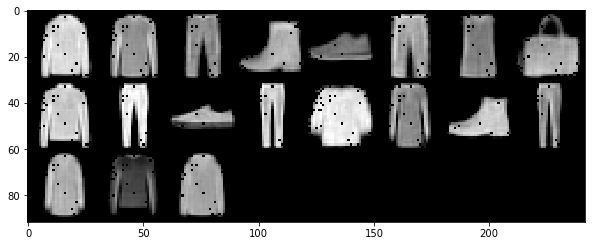

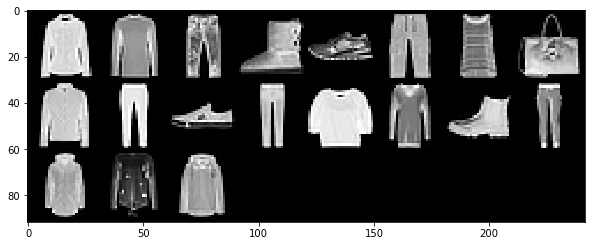

Epoch 36
-------------------------------
loss: 0.023326  [    0/60000]
loss: 0.020345  [ 2000/60000]
loss: 0.020342  [ 4000/60000]
loss: 0.021351  [ 6000/60000]
loss: 0.020761  [ 8000/60000]
loss: 0.020366  [10000/60000]
loss: 0.018747  [12000/60000]
loss: 0.018815  [14000/60000]
loss: 0.026383  [16000/60000]
loss: 0.018341  [18000/60000]
loss: 0.024944  [20000/60000]
loss: 0.019630  [22000/60000]
loss: 0.021416  [24000/60000]
loss: 0.023009  [26000/60000]
loss: 0.022984  [28000/60000]
loss: 0.022545  [30000/60000]
loss: 0.021506  [32000/60000]
loss: 0.017933  [34000/60000]
loss: 0.023747  [36000/60000]
loss: 0.022597  [38000/60000]
loss: 0.019002  [40000/60000]
loss: 0.017005  [42000/60000]
loss: 0.017695  [44000/60000]
loss: 0.017723  [46000/60000]
loss: 0.019665  [48000/60000]
loss: 0.018417  [50000/60000]
loss: 0.016982  [52000/60000]
loss: 0.018674  [54000/60000]
loss: 0.016742  [56000/60000]
loss: 0.022401  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


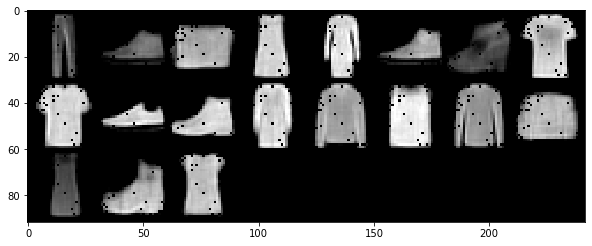

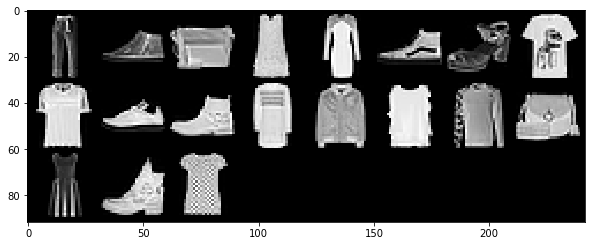

Epoch 37
-------------------------------
loss: 0.019904  [    0/60000]
loss: 0.018826  [ 2000/60000]
loss: 0.015590  [ 4000/60000]
loss: 0.021732  [ 6000/60000]
loss: 0.021877  [ 8000/60000]
loss: 0.021505  [10000/60000]
loss: 0.019464  [12000/60000]
loss: 0.018368  [14000/60000]
loss: 0.021374  [16000/60000]
loss: 0.015898  [18000/60000]
loss: 0.019797  [20000/60000]
loss: 0.021754  [22000/60000]
loss: 0.016995  [24000/60000]
loss: 0.016895  [26000/60000]
loss: 0.019254  [28000/60000]
loss: 0.018784  [30000/60000]
loss: 0.020964  [32000/60000]
loss: 0.016746  [34000/60000]
loss: 0.018840  [36000/60000]
loss: 0.019024  [38000/60000]
loss: 0.024364  [40000/60000]
loss: 0.021765  [42000/60000]
loss: 0.020725  [44000/60000]
loss: 0.020192  [46000/60000]
loss: 0.021934  [48000/60000]
loss: 0.020486  [50000/60000]
loss: 0.026202  [52000/60000]
loss: 0.022768  [54000/60000]
loss: 0.016115  [56000/60000]
loss: 0.016098  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


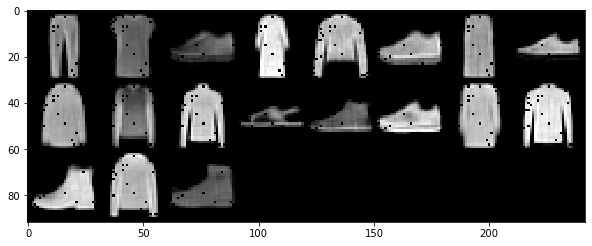

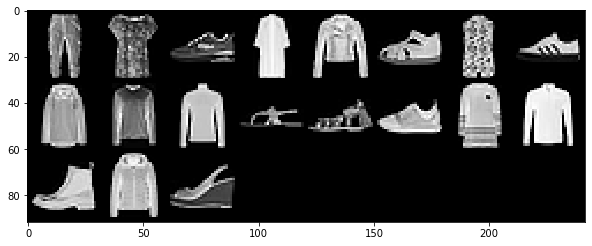

Epoch 38
-------------------------------
loss: 0.018655  [    0/60000]
loss: 0.021669  [ 2000/60000]
loss: 0.016499  [ 4000/60000]
loss: 0.020438  [ 6000/60000]
loss: 0.015414  [ 8000/60000]
loss: 0.020468  [10000/60000]
loss: 0.021086  [12000/60000]
loss: 0.019925  [14000/60000]
loss: 0.021110  [16000/60000]
loss: 0.019201  [18000/60000]
loss: 0.021972  [20000/60000]
loss: 0.023051  [22000/60000]
loss: 0.020421  [24000/60000]
loss: 0.017368  [26000/60000]
loss: 0.016481  [28000/60000]
loss: 0.021697  [30000/60000]
loss: 0.020210  [32000/60000]
loss: 0.018858  [34000/60000]
loss: 0.020174  [36000/60000]
loss: 0.022178  [38000/60000]
loss: 0.022560  [40000/60000]
loss: 0.022638  [42000/60000]
loss: 0.021915  [44000/60000]
loss: 0.023116  [46000/60000]
loss: 0.022344  [48000/60000]
loss: 0.019801  [50000/60000]
loss: 0.021418  [52000/60000]
loss: 0.019676  [54000/60000]
loss: 0.026148  [56000/60000]
loss: 0.019323  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


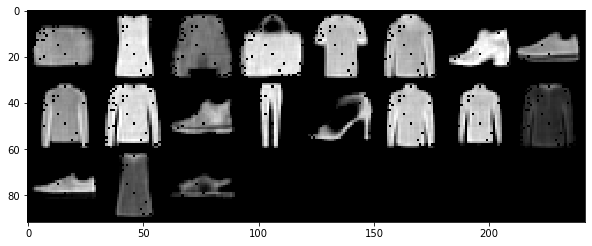

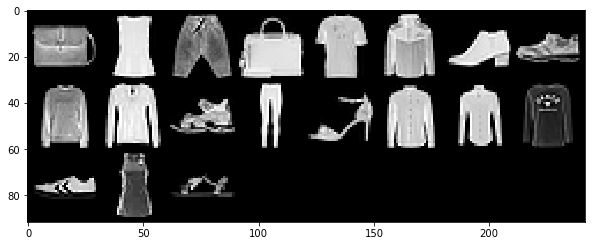

Epoch 39
-------------------------------
loss: 0.019403  [    0/60000]
loss: 0.019581  [ 2000/60000]
loss: 0.019670  [ 4000/60000]
loss: 0.016726  [ 6000/60000]
loss: 0.017980  [ 8000/60000]
loss: 0.019704  [10000/60000]
loss: 0.023238  [12000/60000]
loss: 0.016354  [14000/60000]
loss: 0.027597  [16000/60000]
loss: 0.025917  [18000/60000]
loss: 0.024370  [20000/60000]
loss: 0.022165  [22000/60000]
loss: 0.021091  [24000/60000]
loss: 0.017851  [26000/60000]
loss: 0.018652  [28000/60000]
loss: 0.016726  [30000/60000]
loss: 0.018297  [32000/60000]
loss: 0.020137  [34000/60000]
loss: 0.020412  [36000/60000]
loss: 0.021998  [38000/60000]
loss: 0.020502  [40000/60000]
loss: 0.022155  [42000/60000]
loss: 0.022200  [44000/60000]
loss: 0.015834  [46000/60000]
loss: 0.017855  [48000/60000]
loss: 0.022767  [50000/60000]
loss: 0.018497  [52000/60000]
loss: 0.019268  [54000/60000]
loss: 0.021769  [56000/60000]
loss: 0.020299  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


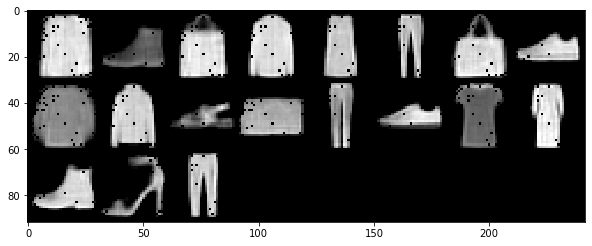

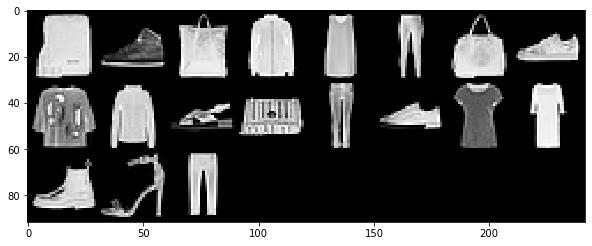

Epoch 40
-------------------------------
loss: 0.018506  [    0/60000]
loss: 0.020098  [ 2000/60000]
loss: 0.021390  [ 4000/60000]
loss: 0.020058  [ 6000/60000]
loss: 0.018553  [ 8000/60000]
loss: 0.020519  [10000/60000]
loss: 0.020639  [12000/60000]
loss: 0.020523  [14000/60000]
loss: 0.018812  [16000/60000]
loss: 0.022085  [18000/60000]
loss: 0.022092  [20000/60000]
loss: 0.023047  [22000/60000]
loss: 0.020042  [24000/60000]
loss: 0.019650  [26000/60000]
loss: 0.021517  [28000/60000]
loss: 0.022814  [30000/60000]
loss: 0.021350  [32000/60000]
loss: 0.019845  [34000/60000]
loss: 0.023808  [36000/60000]
loss: 0.019395  [38000/60000]
loss: 0.020171  [40000/60000]
loss: 0.024702  [42000/60000]
loss: 0.022150  [44000/60000]
loss: 0.027668  [46000/60000]
loss: 0.021203  [48000/60000]
loss: 0.021291  [50000/60000]
loss: 0.016714  [52000/60000]
loss: 0.016976  [54000/60000]
loss: 0.022181  [56000/60000]
loss: 0.023806  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


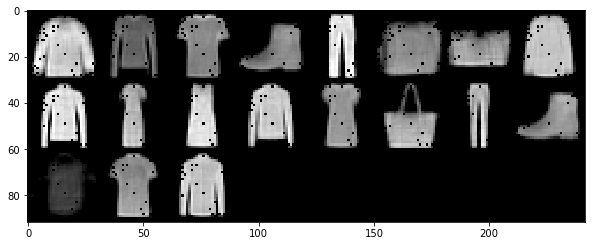

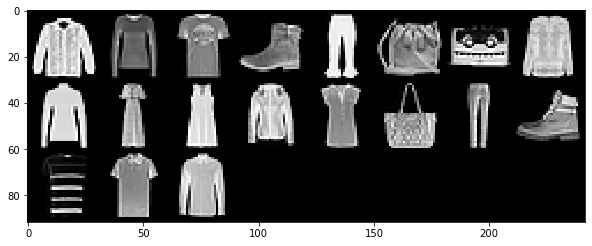

Epoch 41
-------------------------------
loss: 0.022632  [    0/60000]
loss: 0.022138  [ 2000/60000]
loss: 0.021411  [ 4000/60000]
loss: 0.017176  [ 6000/60000]
loss: 0.023380  [ 8000/60000]
loss: 0.025110  [10000/60000]
loss: 0.020919  [12000/60000]
loss: 0.017205  [14000/60000]
loss: 0.023631  [16000/60000]
loss: 0.021229  [18000/60000]
loss: 0.024504  [20000/60000]
loss: 0.020706  [22000/60000]
loss: 0.019479  [24000/60000]
loss: 0.021276  [26000/60000]
loss: 0.023997  [28000/60000]
loss: 0.021158  [30000/60000]
loss: 0.019097  [32000/60000]
loss: 0.019697  [34000/60000]
loss: 0.018298  [36000/60000]
loss: 0.020078  [38000/60000]
loss: 0.017030  [40000/60000]
loss: 0.020063  [42000/60000]
loss: 0.018749  [44000/60000]
loss: 0.019836  [46000/60000]
loss: 0.020321  [48000/60000]
loss: 0.015801  [50000/60000]
loss: 0.023479  [52000/60000]
loss: 0.018787  [54000/60000]
loss: 0.019305  [56000/60000]
loss: 0.022090  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


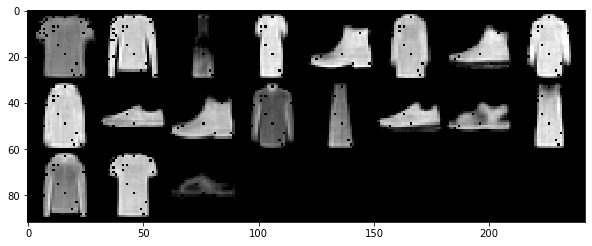

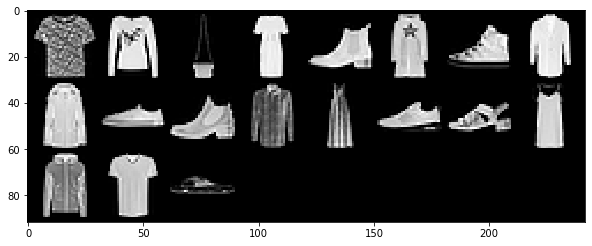

Epoch 42
-------------------------------
loss: 0.018878  [    0/60000]
loss: 0.025007  [ 2000/60000]
loss: 0.019187  [ 4000/60000]
loss: 0.025165  [ 6000/60000]
loss: 0.017584  [ 8000/60000]
loss: 0.019908  [10000/60000]
loss: 0.015867  [12000/60000]
loss: 0.017465  [14000/60000]
loss: 0.019521  [16000/60000]
loss: 0.020419  [18000/60000]
loss: 0.019645  [20000/60000]
loss: 0.020285  [22000/60000]
loss: 0.019425  [24000/60000]
loss: 0.019977  [26000/60000]
loss: 0.019300  [28000/60000]
loss: 0.019969  [30000/60000]
loss: 0.021110  [32000/60000]
loss: 0.018856  [34000/60000]
loss: 0.020687  [36000/60000]
loss: 0.021969  [38000/60000]
loss: 0.019272  [40000/60000]
loss: 0.022640  [42000/60000]
loss: 0.017958  [44000/60000]
loss: 0.015882  [46000/60000]
loss: 0.018446  [48000/60000]
loss: 0.018547  [50000/60000]
loss: 0.019449  [52000/60000]
loss: 0.018886  [54000/60000]
loss: 0.021505  [56000/60000]
loss: 0.018393  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


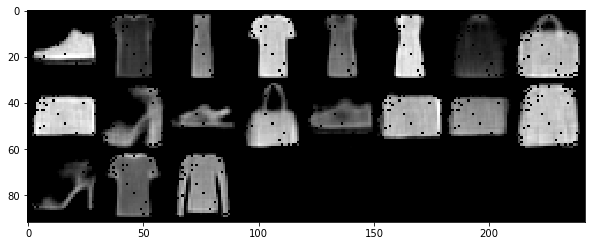

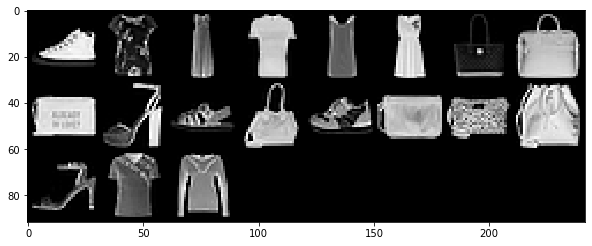

Epoch 43
-------------------------------
loss: 0.020619  [    0/60000]
loss: 0.021926  [ 2000/60000]
loss: 0.019719  [ 4000/60000]
loss: 0.025310  [ 6000/60000]
loss: 0.016176  [ 8000/60000]
loss: 0.023019  [10000/60000]
loss: 0.023004  [12000/60000]
loss: 0.019621  [14000/60000]
loss: 0.019266  [16000/60000]
loss: 0.024505  [18000/60000]
loss: 0.023781  [20000/60000]
loss: 0.023198  [22000/60000]
loss: 0.017011  [24000/60000]
loss: 0.024297  [26000/60000]
loss: 0.020213  [28000/60000]
loss: 0.021891  [30000/60000]
loss: 0.020792  [32000/60000]
loss: 0.020339  [34000/60000]
loss: 0.022277  [36000/60000]
loss: 0.018763  [38000/60000]
loss: 0.022313  [40000/60000]
loss: 0.023352  [42000/60000]
loss: 0.018274  [44000/60000]
loss: 0.027846  [46000/60000]
loss: 0.016117  [48000/60000]
loss: 0.021073  [50000/60000]
loss: 0.019483  [52000/60000]
loss: 0.015896  [54000/60000]
loss: 0.019390  [56000/60000]
loss: 0.019297  [58000/60000]


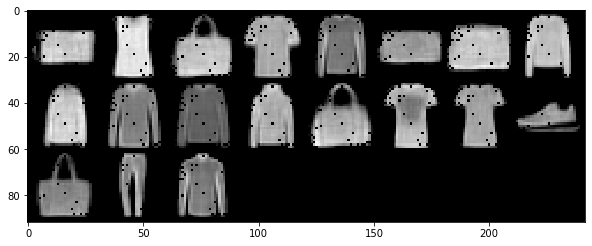

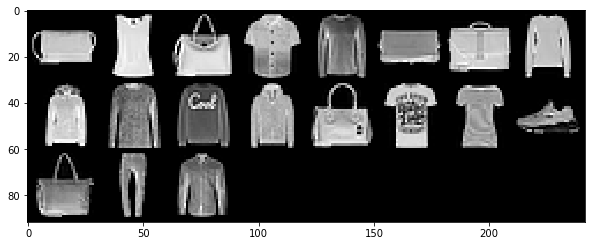

Epoch 44
-------------------------------
loss: 0.021824  [    0/60000]
loss: 0.021115  [ 2000/60000]
loss: 0.019348  [ 4000/60000]
loss: 0.023272  [ 6000/60000]
loss: 0.021823  [ 8000/60000]
loss: 0.020300  [10000/60000]
loss: 0.018484  [12000/60000]
loss: 0.021549  [14000/60000]
loss: 0.022298  [16000/60000]
loss: 0.017843  [18000/60000]
loss: 0.022263  [20000/60000]
loss: 0.020754  [22000/60000]
loss: 0.021195  [24000/60000]
loss: 0.024629  [26000/60000]
loss: 0.023288  [28000/60000]
loss: 0.017348  [30000/60000]
loss: 0.020584  [32000/60000]
loss: 0.023830  [34000/60000]
loss: 0.020126  [36000/60000]
loss: 0.018919  [38000/60000]
loss: 0.022283  [40000/60000]
loss: 0.021183  [42000/60000]
loss: 0.018813  [44000/60000]
loss: 0.022027  [46000/60000]
loss: 0.021766  [48000/60000]
loss: 0.019365  [50000/60000]
loss: 0.020046  [52000/60000]
loss: 0.015078  [54000/60000]
loss: 0.024833  [56000/60000]
loss: 0.018470  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


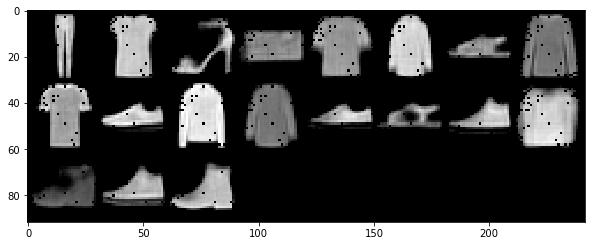

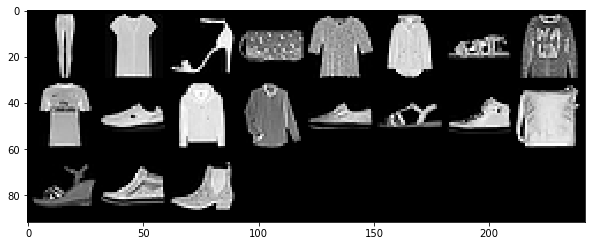

Epoch 45
-------------------------------
loss: 0.020394  [    0/60000]
loss: 0.017965  [ 2000/60000]
loss: 0.019894  [ 4000/60000]
loss: 0.023183  [ 6000/60000]
loss: 0.020460  [ 8000/60000]
loss: 0.019179  [10000/60000]
loss: 0.022600  [12000/60000]
loss: 0.022672  [14000/60000]
loss: 0.022673  [16000/60000]
loss: 0.018469  [18000/60000]
loss: 0.021874  [20000/60000]
loss: 0.023799  [22000/60000]
loss: 0.017960  [24000/60000]
loss: 0.019380  [26000/60000]
loss: 0.021766  [28000/60000]
loss: 0.023100  [30000/60000]
loss: 0.021277  [32000/60000]
loss: 0.020221  [34000/60000]
loss: 0.020684  [36000/60000]
loss: 0.021356  [38000/60000]
loss: 0.021382  [40000/60000]
loss: 0.017517  [42000/60000]
loss: 0.016474  [44000/60000]
loss: 0.019728  [46000/60000]
loss: 0.020826  [48000/60000]
loss: 0.024820  [50000/60000]
loss: 0.019257  [52000/60000]
loss: 0.017883  [54000/60000]
loss: 0.023421  [56000/60000]
loss: 0.023231  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


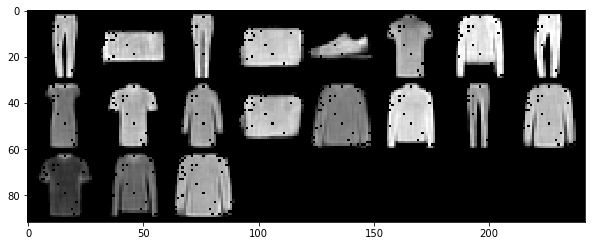

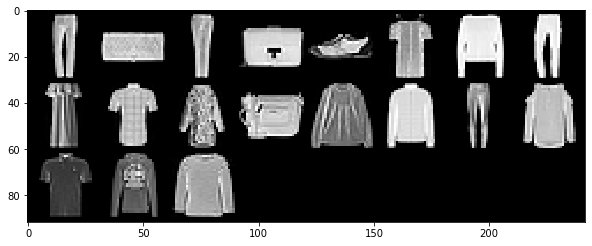

Epoch 46
-------------------------------
loss: 0.017607  [    0/60000]
loss: 0.018837  [ 2000/60000]
loss: 0.018152  [ 4000/60000]
loss: 0.018018  [ 6000/60000]
loss: 0.019979  [ 8000/60000]
loss: 0.018226  [10000/60000]
loss: 0.019717  [12000/60000]
loss: 0.017973  [14000/60000]
loss: 0.021881  [16000/60000]
loss: 0.016772  [18000/60000]
loss: 0.021468  [20000/60000]
loss: 0.016289  [22000/60000]
loss: 0.018489  [24000/60000]
loss: 0.018502  [26000/60000]
loss: 0.020534  [28000/60000]
loss: 0.020111  [30000/60000]
loss: 0.020441  [32000/60000]
loss: 0.023965  [34000/60000]
loss: 0.018810  [36000/60000]
loss: 0.025836  [38000/60000]
loss: 0.021926  [40000/60000]
loss: 0.019289  [42000/60000]
loss: 0.020701  [44000/60000]
loss: 0.020931  [46000/60000]
loss: 0.022099  [48000/60000]
loss: 0.016331  [50000/60000]
loss: 0.019379  [52000/60000]
loss: 0.017443  [54000/60000]
loss: 0.017317  [56000/60000]
loss: 0.019787  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


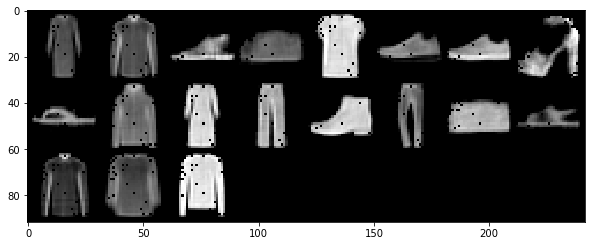

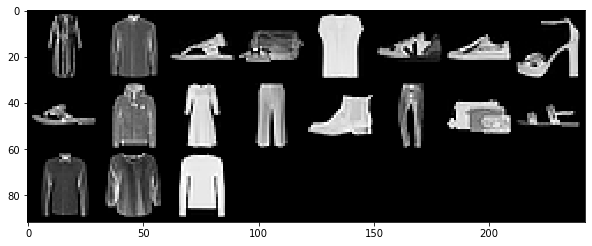

Epoch 47
-------------------------------
loss: 0.021529  [    0/60000]
loss: 0.020044  [ 2000/60000]
loss: 0.018913  [ 4000/60000]
loss: 0.024467  [ 6000/60000]
loss: 0.020925  [ 8000/60000]
loss: 0.023977  [10000/60000]
loss: 0.018969  [12000/60000]
loss: 0.015348  [14000/60000]
loss: 0.024129  [16000/60000]
loss: 0.021634  [18000/60000]
loss: 0.024689  [20000/60000]
loss: 0.020363  [22000/60000]
loss: 0.021758  [24000/60000]
loss: 0.025806  [26000/60000]
loss: 0.017076  [28000/60000]
loss: 0.019597  [30000/60000]
loss: 0.018516  [32000/60000]
loss: 0.017610  [34000/60000]
loss: 0.028584  [36000/60000]
loss: 0.020211  [38000/60000]
loss: 0.021587  [40000/60000]
loss: 0.021631  [42000/60000]
loss: 0.020087  [44000/60000]
loss: 0.017441  [46000/60000]
loss: 0.020233  [48000/60000]
loss: 0.021682  [50000/60000]
loss: 0.019019  [52000/60000]
loss: 0.017866  [54000/60000]
loss: 0.024142  [56000/60000]
loss: 0.020596  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


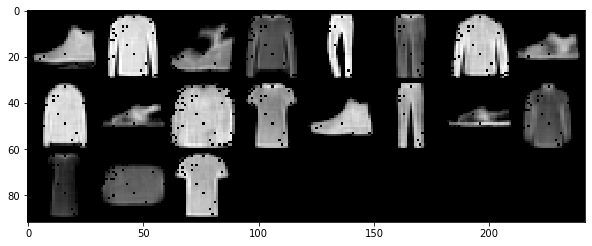

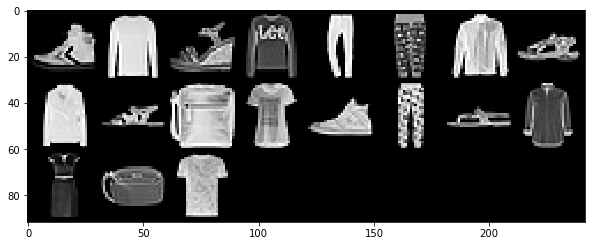

Epoch 48
-------------------------------
loss: 0.018205  [    0/60000]
loss: 0.018859  [ 2000/60000]
loss: 0.023561  [ 4000/60000]
loss: 0.020285  [ 6000/60000]
loss: 0.019228  [ 8000/60000]
loss: 0.022633  [10000/60000]
loss: 0.021385  [12000/60000]
loss: 0.020606  [14000/60000]
loss: 0.018464  [16000/60000]
loss: 0.017924  [18000/60000]
loss: 0.017743  [20000/60000]
loss: 0.023514  [22000/60000]
loss: 0.021984  [24000/60000]
loss: 0.020688  [26000/60000]
loss: 0.016557  [28000/60000]
loss: 0.019406  [30000/60000]
loss: 0.019472  [32000/60000]
loss: 0.019781  [34000/60000]
loss: 0.017252  [36000/60000]
loss: 0.016685  [38000/60000]
loss: 0.017790  [40000/60000]
loss: 0.017028  [42000/60000]
loss: 0.025919  [44000/60000]
loss: 0.020951  [46000/60000]
loss: 0.019198  [48000/60000]
loss: 0.021411  [50000/60000]
loss: 0.026309  [52000/60000]
loss: 0.022057  [54000/60000]
loss: 0.018656  [56000/60000]
loss: 0.019899  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


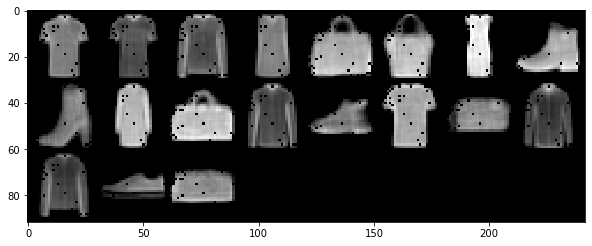

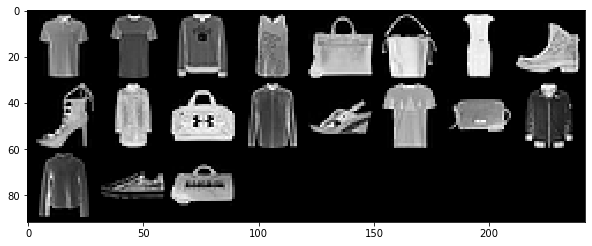

Epoch 49
-------------------------------
loss: 0.021558  [    0/60000]
loss: 0.017509  [ 2000/60000]
loss: 0.021441  [ 4000/60000]
loss: 0.025564  [ 6000/60000]
loss: 0.017623  [ 8000/60000]
loss: 0.018052  [10000/60000]
loss: 0.019773  [12000/60000]
loss: 0.019950  [14000/60000]
loss: 0.021478  [16000/60000]
loss: 0.027499  [18000/60000]
loss: 0.019883  [20000/60000]
loss: 0.019887  [22000/60000]
loss: 0.017078  [24000/60000]
loss: 0.018332  [26000/60000]
loss: 0.020318  [28000/60000]
loss: 0.017559  [30000/60000]
loss: 0.020596  [32000/60000]
loss: 0.017945  [34000/60000]
loss: 0.022808  [36000/60000]
loss: 0.015904  [38000/60000]
loss: 0.019011  [40000/60000]
loss: 0.022442  [42000/60000]
loss: 0.019464  [44000/60000]
loss: 0.022041  [46000/60000]
loss: 0.023036  [48000/60000]
loss: 0.025156  [50000/60000]
loss: 0.021985  [52000/60000]
loss: 0.019208  [54000/60000]
loss: 0.015586  [56000/60000]
loss: 0.022053  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


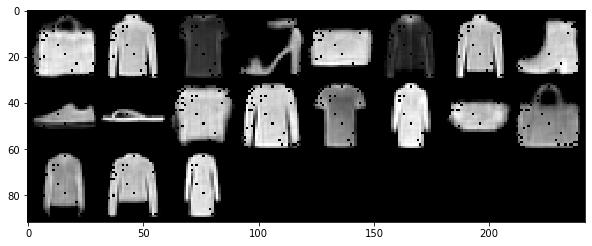

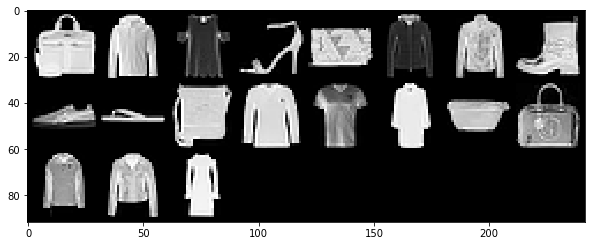

Epoch 50
-------------------------------
loss: 0.018151  [    0/60000]
loss: 0.016759  [ 2000/60000]
loss: 0.019554  [ 4000/60000]
loss: 0.018184  [ 6000/60000]
loss: 0.022422  [ 8000/60000]
loss: 0.018607  [10000/60000]
loss: 0.020977  [12000/60000]
loss: 0.024846  [14000/60000]
loss: 0.017212  [16000/60000]
loss: 0.022620  [18000/60000]
loss: 0.014591  [20000/60000]
loss: 0.017303  [22000/60000]
loss: 0.017820  [24000/60000]
loss: 0.018997  [26000/60000]
loss: 0.022222  [28000/60000]
loss: 0.026583  [30000/60000]
loss: 0.018152  [32000/60000]
loss: 0.020181  [34000/60000]
loss: 0.016965  [36000/60000]
loss: 0.016973  [38000/60000]
loss: 0.023406  [40000/60000]
loss: 0.019934  [42000/60000]
loss: 0.018806  [44000/60000]
loss: 0.024410  [46000/60000]
loss: 0.022426  [48000/60000]
loss: 0.021310  [50000/60000]
loss: 0.017159  [52000/60000]
loss: 0.023559  [54000/60000]
loss: 0.021230  [56000/60000]
loss: 0.019309  [58000/60000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


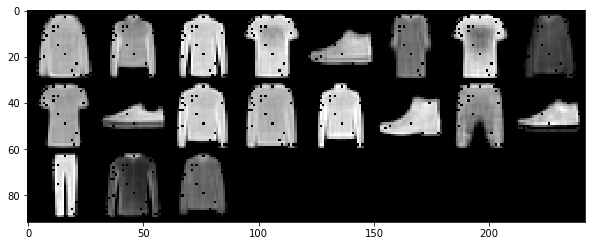

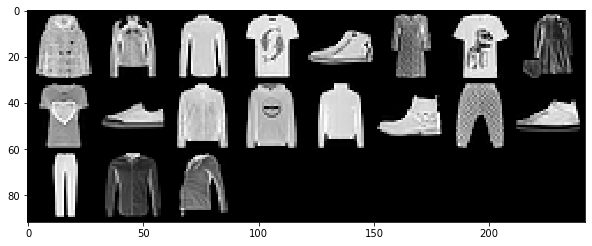

Done!


In [13]:
# define hyper params
# updating rate for each batch/epoch
learning_rate = 1e-3
# number of data samples to propagate through network before updating params
batch_size = 64
# iteration times, we used 50 to, on the one hand, test our gpu performance out of curiosity and, on the other
# hand, see, how much impact the number of epochs has on the performance of the net. 
epochs = 50
# using CrossEntropy for numeric stability, combines LogSoftmax and NLLLoss
# useful when training a problem with C classes

# We investigated multiple loss functions, including but not limited to CrossEntropyLoss, KLDivLoss, and BCELoss
# Through empirical tests, we found, that the MSELoss works well for denoising in our network. 
# The denoising task, in contrast to the classification task, is a regression task, hence, common regression 
# losses like MSE work well in this case
loss_fn = nn.MSELoss()
# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# use data loader to obtain batch training and test data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 20, shuffle=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model)
print("Done!")